In [121]:
# # Google Colab specific
# %cd ~/../content
# !rm -rf openet

# !git clone https://github.com/aetriusgx/openet.git
# %cd openet

# Preparation

In [122]:
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [123]:
# Styling Cell
sns.set_theme(context="notebook", style="whitegrid")

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Metric Functions

### calculate_metrics
This function calculate the mean absolute error (mae), root mean squared error (rmse), mean forecast error (bias), correlation coefficient (R), and skill score.

MAE, RMSE, and R are calculated using sklearn's metric module.

Skill score is calculated by getting the climatology for each field within the input's date range.
* Negative skill scores indicate the MSE for forecast is larger than the MSE for climatology
* Positive skill scores indicate otherwise

The function is very flexible given the data is formatted appropriately. It has the option of enabling normalization which is based on the average specified variable (ET, ETo, or ETof) throughout that field's historical data.

In [124]:
def calculate_metrics(data: pd.DataFrame, *, 
                      historical: pd.DataFrame, 
                      climatology_ref: pd.DataFrame,
                      avgs_ref: pd.DataFrame,
                      actual: str, expected: str, 
                      normalize: bool = False) -> pd.Series:
	# Calculate error metrics
    mae: float = mean_absolute_error(data[actual], data[expected])
    forecast_mse: float = mean_squared_error(data[actual], data[expected])
    rmse: float = np.sqrt(forecast_mse)

    # Correlation Coefficient (R)
    cor = data[actual].corr(data[expected]).astype(float)
    
    # Mean Forecast Bias determines if the forecast is overshooting or undershooting.
    # Greater positive number indicates overshooting.
    bias: float = np.mean(data[expected] - data[actual])

	# Climatology uses the mean actual variable for that time of year using historical data.
    field = data.head(1).squeeze()
    start_date = data['time'].min().dayofyear
    end_date = data['time'].max().dayofyear

	# Filter the climatology reference
    field_mask = (climatology_ref.index.get_level_values(0) == field['field_id'])
    crop_mask = (climatology_ref.index.get_level_values(1) == field['crop'])
    date_mask = ((climatology_ref.index.get_level_values(2) >= start_date) & (climatology_ref.index.get_level_values(2) <= end_date))
    
    climatology = climatology_ref[field_mask & crop_mask & date_mask][actual]
    climatology_mse = mean_squared_error(data[actual], climatology)

	# Positive skill score indicates the error in climatology is greater than forecast.
    # This means that forecast is outperforming climatology.
    skill_score = 1 - np.max(np.min((forecast_mse / climatology_mse), initial=2), initial=-1)

    if normalize:
    	avg: float = avgs_ref[avgs_ref.index.get_level_values(0) == field['field_id']][actual].values[0]

    	mae: float = mae.astype(float) / avg.astype(float)
    	rmse = np.sqrt(forecast_mse.astype(float) / avg.astype(float))
    	bias = bias.astype(float) / avg.astype(float)

    return pd.Series({
    	'mae': mae.round(2),
    	'rmse': rmse.round(2),
    	'corr': cor.round(2),
    	'bias': bias.round(2),
    	'skill_score': skill_score.round(2)
	})

### eval_metrics
This function evaluates the metrics for each variable. The output is a DataFrame containing the metrics with a column specifying which variable (ET, ETo, ETof)

In [125]:
def eval_metrics(table: pd.DataFrame, by=['field_id', 'crop'], **kwargs) -> pd.DataFrame:
    metrics_table = pd.DataFrame(columns=["field_id", "variable", "crop", "mae", "rmse", "corr", "bias", "skill_score"])

    et_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_et", "expected_et"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_et', expected='expected_et', **kwargs).reset_index()
    et_metrics['variable'] = "ET"

    metrics_table = pd.concat([et_metrics.astype(metrics_table.dtypes), metrics_table.astype(et_metrics.dtypes)], ignore_index=True)

    eto_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_eto", "expected_eto"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_eto', expected='expected_eto', **kwargs).reset_index()
    eto_metrics['variable'] = "ETo"
    metrics_table = pd.concat([eto_metrics.astype(metrics_table.dtypes), metrics_table.astype(eto_metrics.dtypes)], ignore_index=True)

    etof_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_etof", "expected_etof"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_etof', expected='expected_etof', **kwargs).reset_index()
    etof_metrics['variable'] = "ETof"
    metrics_table = pd.concat([etof_metrics.astype(metrics_table.dtypes), metrics_table.astype(etof_metrics.dtypes)], ignore_index=True)

    return metrics_table

### timeseries_rel
This plot function utilizes the seaborn relplot method to create grids of plots. Particularly useful for showing distribution on one cell.

In [126]:
def timeseries_rel(data, *, y, plot='rel',
                   col=None, row=None, hue=None, kind='line', refline=None,
                   title='', ylabel='', as_percent=False, tighten=False,
                   errorbar=None, export_img: bool|str=None, title_template={}, **kwargs):
    match plot:
        case 'rel':
            rel = sns.relplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case 'dis': 
            rel = sns.displot(data=data, x=y, col=col, row=row, hue=hue, kind=kind, **kwargs)
        case 'cat':
            rel = sns.catplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case 'lm':
            rel = sns.lmplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case _:
            raise Exception('Not a valid plot type.')

    # Relabel y axis
    if ylabel: rel.set_ylabels(ylabel)
    # Relabel x axis
    rel.tick_params(axis='x', rotation=90)
    plt.suptitle(title, y=1.02);
    rel.set_titles(**title_template);

    if as_percent is True:
        for ax in rel.axes.flat:
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    if plot != 'dis':
        rel.set_xlabels('Forecasting Date')
        for ax in rel.axes.flat:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

    if tighten:
        rel.figure.subplots_adjust(wspace=0, hspace=0.1)

    if refline:
        rel.refline(**refline)

    if type(export_img) is bool and export_img is True: 
        rel.savefig(fname=f'images/monterey/{str(title)}')
    elif type(export_img) is str: 
        rel.savefig(fname=f'images/monterey/{export_img}')

    return rel

### trim_extremes
Trim the edges of the DataFrame along provided columns with provided threshold.

In [127]:
def trim_extremes(data, *, cols, threshold):
    # Convert single input as list
    if type(cols) is not list:
        cols = [cols]
    # Go through each column. Rank the values by % then remove the extremes.
    for c in cols:
        data[f'{c}_pct'] = data[c].rank(pct=True)
        data.drop(index=data[(data[f'{c}_pct'] <= threshold)].index, inplace=True)
        data.drop(columns=f'{c}_pct', inplace=True)
    return data

# Initial version

## Point Analysis

### Historical Data Import

In [128]:
historical = pd.read_csv('./data/monterey_historical.csv', low_memory=False)
historical['time'] = pd.to_datetime(historical['time'])
historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355932 entries, 0 to 2355931
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   field_id     object        
 1   crop         int64         
 2   time         datetime64[ns]
 3   actual_et    float64       
 4   actual_eto   float64       
 5   actual_etof  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 107.8+ MB


### Forecast Table Build

In [129]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"data/forecasts/monterey/").glob("*.csv")

for file in files:
    # splits into [$date, 'forecast.csv']
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384694 entries, 0 to 8384693
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   field_id          object        
 1   crop              int64         
 2   time              datetime64[ns]
 3   expected_et       float64       
 4   expected_eto      float64       
 5   expected_etof     float64       
 6   forecasting_date  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 447.8+ MB


### Main Data Table compilation

In [130]:
dt = historical.loc[(historical['time'].dt.year == 2024), :]
dt = dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
dt

forecasting_date   field_id  crop       time  actual_et  actual_eto  \
0             2024-07-15  CA_244000    47 2024-01-01      0.718       1.103   
1             2024-07-15  CA_244000    47 2024-01-02      0.668       1.018   
2             2024-07-15  CA_244000    47 2024-01-03      1.403       2.122   
3             2024-07-15  CA_244000    47 2024-01-04      1.698       2.546   
4             2024-07-15  CA_244000    47 2024-01-05      1.027       1.528   
...                  ...        ...   ...        ...        ...         ...   
8384689       2024-01-29  CA_420924    68 2024-12-27        NaN         NaN   
8384690       2024-01-29  CA_420924    68 2024-12-28        NaN         NaN   
8384691       2024-01-29  CA_420924    68 2024-12-29        NaN         NaN   
8384692       2024-01-29  CA_420924    68 2024-12-30        NaN         NaN   
8384693       2024-01-29  CA_420924    68 2024-12-31        NaN         NaN   

         actual_etof  expected_et  expected_eto  expected_etof  
0              0.650        0.718         1.103          0.650  
1              0.656        0.668         1.018          0.656  
2              0.661        1.403         2.122          0.661  
3              0.667        1.698         2.546          0.667  
4              0.672        1.027         1.528          0.672  
...              ...          ...           ...            ...  
8384689          NaN        0.635         1.316          0.581  
8384690          NaN        0.674         1.180          0.580  
8384691          NaN        0.671         1.076          0.576  
8384692          NaN        0.705         1.074          0.574  
8384693          NaN        0.757         1.108          0.577  

[8384694 rows x 10 columns]

#### Add geographical data

In [131]:
# Add additional data to the data table
monterey_points = pd.read_csv("./data/Monterey.csv", low_memory=False).set_index("OPENET_ID").rename_axis("field_id")

# Expand .geo column into lon, lat columns
monterey_geo = (monterey_points[".geo"]
                .apply(lambda x: pd.Series(dict(json.loads(x))))['coordinates']
                .apply(lambda x: pd.Series(list(x), index=['longitude', 'latitude'])))
monterey_geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 739 entries, CA_253578 to CA_251078
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  739 non-null    float64
 1   latitude   739 non-null    float64
dtypes: float64(2)
memory usage: 17.3+ KB


In [132]:
monterey_points['CROP_2023'].value_counts()

CROP_2023
47     513
69     136
61      74
72       5
37       4
122      2
211      2
215      2
68       1
Name: count, dtype: int64

In [133]:
dt = dt.join(monterey_geo, how="left", on=["field_id"], validate="many_to_one")
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384694 entries, 0 to 8384693
Data columns (total 12 columns):
 #   Column            Dtype         
---  ------            -----         
 0   forecasting_date  datetime64[ns]
 1   field_id          object        
 2   crop              int64         
 3   time              datetime64[ns]
 4   actual_et         float64       
 5   actual_eto        float64       
 6   actual_etof       float64       
 7   expected_et       float64       
 8   expected_eto      float64       
 9   expected_etof     float64       
 10  longitude         float64       
 11  latitude          float64       
dtypes: datetime64[ns](2), float64(8), int64(1), object(1)
memory usage: 767.6+ MB


### Add USDA crop data

In [134]:
# Add crop data
cdl_codes = pd.read_csv("./data/cdl_codes.csv", low_memory=False).set_index("Codes")

dt = dt.join(cdl_codes, how="left", on="crop", validate="many_to_many")
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384694 entries, 0 to 8384693
Data columns (total 19 columns):
 #   Column            Dtype         
---  ------            -----         
 0   forecasting_date  datetime64[ns]
 1   field_id          object        
 2   crop              int64         
 3   time              datetime64[ns]
 4   actual_et         float64       
 5   actual_eto        float64       
 6   actual_etof       float64       
 7   expected_et       float64       
 8   expected_eto      float64       
 9   expected_etof     float64       
 10  longitude         float64       
 11  latitude          float64       
 12  Class_Names       object        
 13  ESRI_Red          int64         
 14  ESRI_Green        int64         
 15  ESRI_Blue         int64         
 16  Erdas_Red         float64       
 17  Erdas_Green       float64       
 18  Erdas_Blue        float64       
dtypes: datetime64[ns](2), float64(11), int64(4), object(2)
memory usage: 1.2+ GB


#### Add Field Metadata

In [135]:
# Import table using only field and hectare columns
field_metadata = pd.read_json('./data/geo/field_metadata.json')[['field_id', 'hectares']]
# Reformat field IDs to be same convention as the other tables.
field_metadata['field_id'] = 'CA_' + field_metadata['field_id'].astype(str).str[1:]
field_metadata = field_metadata.set_index('field_id')
field_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, CA_244000 to CA_258026
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hectares  729 non-null    float64
dtypes: float64(1)
memory usage: 11.4+ KB


In [136]:
dt = dt.join(field_metadata, how='left', on='field_id', validate='many_to_one')
dt.info()
dt.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384694 entries, 0 to 8384693
Data columns (total 20 columns):
 #   Column            Dtype         
---  ------            -----         
 0   forecasting_date  datetime64[ns]
 1   field_id          object        
 2   crop              int64         
 3   time              datetime64[ns]
 4   actual_et         float64       
 5   actual_eto        float64       
 6   actual_etof       float64       
 7   expected_et       float64       
 8   expected_eto      float64       
 9   expected_etof     float64       
 10  longitude         float64       
 11  latitude          float64       
 12  Class_Names       object        
 13  ESRI_Red          int64         
 14  ESRI_Green        int64         
 15  ESRI_Blue         int64         
 16  Erdas_Red         float64       
 17  Erdas_Green       float64       
 18  Erdas_Blue        float64       
 19  hectares          float64       
dtypes: datetime64[ns](2), float64(12), int64(4), o

forecasting_date   field_id  crop       time  actual_et  actual_eto  \
0       2024-07-15  CA_244000    47 2024-01-01      0.718       1.103   
1       2024-07-15  CA_244000    47 2024-01-02      0.668       1.018   
2       2024-07-15  CA_244000    47 2024-01-03      1.403       2.122   
3       2024-07-15  CA_244000    47 2024-01-04      1.698       2.546   
4       2024-07-15  CA_244000    47 2024-01-05      1.027       1.528   

   actual_etof  expected_et  expected_eto  expected_etof  longitude  \
0        0.650        0.718         1.103          0.650 -121.54054   
1        0.656        0.668         1.018          0.656 -121.54054   
2        0.661        1.403         2.122          0.661 -121.54054   
3        0.667        1.698         2.546          0.667 -121.54054   
4        0.672        1.027         1.528          0.672 -121.54054   

    latitude         Class_Names  ESRI_Red  ESRI_Green  ESRI_Blue  Erdas_Red  \
0  36.537255  Misc Vegs & Fruits       255         102        102        1.0   
1  36.537255  Misc Vegs & Fruits       255         102        102        1.0   
2  36.537255  Misc Vegs & Fruits       255         102        102        1.0   
3  36.537255  Misc Vegs & Fruits       255         102        102        1.0   
4  36.537255  Misc Vegs & Fruits       255         102        102        1.0   

   Erdas_Green  Erdas_Blue  hectares  
0          0.4         0.4   263.816  
1          0.4         0.4   263.816  
2          0.4         0.4   263.816  
3          0.4         0.4   263.816  
4          0.4         0.4   263.816

#### List of identifiers

In [137]:
forecast_dates = forecasting_table['forecasting_date'].unique()
fields = dt['field_id'].unique()
crops = dt['crop'].unique()

### Reference Tables

The tables below are calculated prior to speed up metric calculations.

#### Average ET/ETo/ETof for 2024
This table will be used as a reference for any metric and plot calculations

In [138]:
avgs_table = dt.groupby(['field_id', 'crop'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
avgs_table.head()

actual_et  actual_eto  actual_etof
field_id  crop                                    
CA_244000 47     2.694974    3.922391     0.688135
CA_244018 47     1.863444    3.390895     0.527914
CA_244025 47     2.227602    3.396353     0.680094
CA_244035 69     1.451620    3.018462     0.512981
CA_244053 47     1.691609    3.390895     0.494150

#### Climatology Reference
The table below records the average conditions for each field for each day of the year.

In [139]:
# Create a column for day of year
historical['doy'] = historical['time'].dt.dayofyear
# Group by field, crop, and doy then calculate the average conditions
climatology_table = historical.groupby(['field_id', 'crop', 'doy'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
climatology_table

actual_et  actual_eto  actual_etof
field_id  crop doy                                    
CA_244000 47   1     0.910333    1.291889     0.691333
               2     0.926556    1.310778     0.696556
               3     0.999778    1.423778     0.701222
               4     1.162000    1.697333     0.691111
               5     1.102111    1.556000     0.694111
...                       ...         ...          ...
CA_420924 68   362   0.813125    1.293625     0.643375
               363   0.781875    1.202875     0.658250
               364   0.750250    1.146250     0.673250
               365   0.570625    0.851125     0.690500
               366   0.728000    1.089500     0.640000

[270474 rows x 3 columns]

### Calculation

In [140]:
analysis_end_date = datetime(year=2024, month=8, day=1)

Est. run time: 21m

In [141]:
# metrics_norm = (dt[(dt['time'] > dt['forecasting_date']) & (dt['time'] < (dt['forecasting_date']) + timedelta(days=7)) & (dt['time'] < analysis_end_date)]
#                 .groupby(['forecasting_date'])[list(dt.columns)]
#                 .apply(eval_metrics, normalize=True))
# metrics_norm.reset_index().to_csv('data/metrics/monterey_metrics_normalized.csv', index=False)

In [142]:
metrics_norm = pd.read_csv('data/metrics/monterey_metrics_normalized.csv').drop(['level_1'], axis=1)
metrics_norm['forecasting_date'] = pd.to_datetime(metrics_norm['forecasting_date'])

In [143]:
metrics_norm = (metrics_norm.groupby(['forecasting_date', 'variable'])[['field_id', 'crop', 'mae', 'rmse', 'bias', 'corr', 'skill_score']]
                .apply(trim_extremes, cols=['mae', 'rmse', 'bias', 'corr', 'skill_score'], threshold=0.02))
metrics_norm.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 63839 entries, (Timestamp('2024-01-01 00:00:00'), 'ET', 1478) to (Timestamp('2024-07-29 00:00:00'), 'ETof', 67248)
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   field_id     63839 non-null  object 
 1   crop         63839 non-null  int64  
 2   mae          63839 non-null  float64
 3   rmse         63839 non-null  float64
 4   bias         63839 non-null  float64
 5   corr         63045 non-null  float64
 6   skill_score  63839 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 6.3+ MB


In [144]:
metrics_norm.head()

field_id  crop   mae  rmse  bias  corr  \
forecasting_date variable                                                 
2024-01-01       ET       1478  CA_244000    47  0.12  0.27 -0.11  0.15   
                          1479  CA_244018    47  0.11  0.17 -0.03  0.67   
                          1480  CA_244025    47  0.17  0.29 -0.15 -0.18   
                          1481  CA_244035    69  0.10  0.16 -0.09 -0.05   
                          1482  CA_244053    47  0.21  0.31 -0.21 -0.08   

                                skill_score  
forecasting_date variable                    
2024-01-01       ET       1478        -1.00  
                          1479        -0.20  
                          1480        -0.99  
                          1481        -1.00  
                          1482        -1.00

#### Crop metrics

In [145]:
# crop_metrics = (dt[(dt['time'] > dt['forecasting_date']) & (dt['time'] < (dt['forecasting_date']) + timedelta(days=7)) & (dt['time'] < analysis_end_date)]
#                 .groupby(by=['forecasting_date', 'crop'])[list(dt.columns)]
#                 .apply(eval_metrics, normalize=True))
# crop_metrics.to_csv('data/metrics/montery_crop_metrics.csv')

In [146]:
crop_metrics = pd.read_csv('data/metrics/montery_crop_metrics.csv', low_memory=False).drop(['Unnamed: 2', 'crop.1'], axis=1)
crop_metrics['forecasting_date'] = pd.to_datetime(crop_metrics['forecasting_date'])

In [147]:
crop_metrics = (crop_metrics.groupby(['forecasting_date', 'variable'])[['field_id', 'crop', 'mae', 'rmse', 'bias', 'corr', 'skill_score']]
                    .apply(trim_extremes, cols=['mae', 'rmse', 'bias', 'corr', 'skill_score'], threshold=0.02))
crop_metrics.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 63839 entries, (Timestamp('2024-01-01 00:00:00'), 'ET', 8) to (Timestamp('2024-07-29 00:00:00'), 'ETof', 68722)
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   field_id     63839 non-null  object 
 1   crop         63839 non-null  int64  
 2   mae          63839 non-null  float64
 3   rmse         63839 non-null  float64
 4   bias         63839 non-null  float64
 5   corr         63045 non-null  float64
 6   skill_score  63839 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 6.3+ MB


### Visualization

#### Metric Correlation

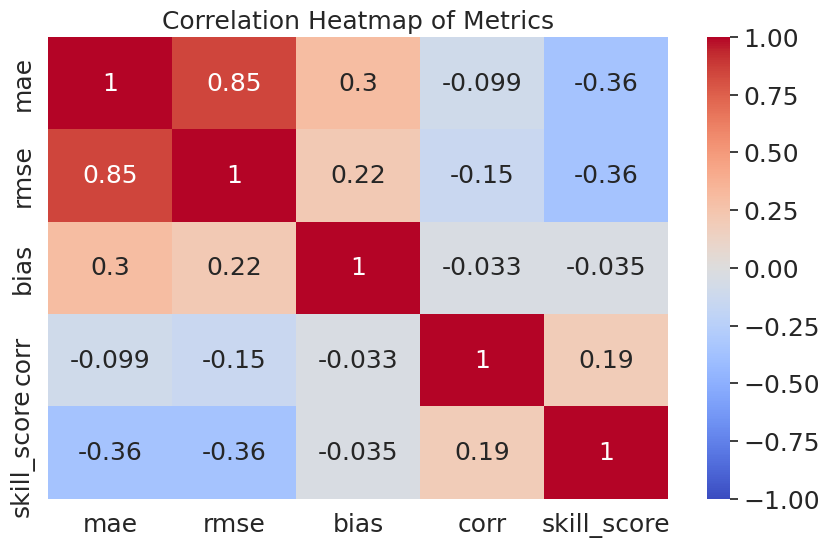

In [148]:
plt.figure(figsize=(10, 6))
metrics = ['mae', 'rmse', 'bias', 'corr', 'skill_score']
corr_matrix = metrics_norm[metrics].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Metrics')
plt.savefig('images/monterey/field_metric_correlation.png')

#### Distribution of Metrics

In [149]:
# First reshape data from wide-form to long-form
metrics_long = metrics_norm.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')

In [150]:
# To help with visualization, map proper names to the stats
stat_propers = {
    'mae': 'Mean Absolute Error',
    'rmse': 'Root Mean Absolute Error',
    'bias': 'Mean Forecast Bias',
    'corr': 'Correlation Coefficient',
    'skill_score': 'Skill Score'
}
metrics_long['name'] = metrics_long['stat'].map(stat_propers)
metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191517 entries, 0 to 191516
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   forecasting_date  191517 non-null  datetime64[ns]
 1   field_id          191517 non-null  object        
 2   crop              191517 non-null  int64         
 3   variable          191517 non-null  object        
 4   stat              191517 non-null  object        
 5   value             191517 non-null  float64       
 6   name              191517 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 10.2+ MB


##### Boxplot Distribution

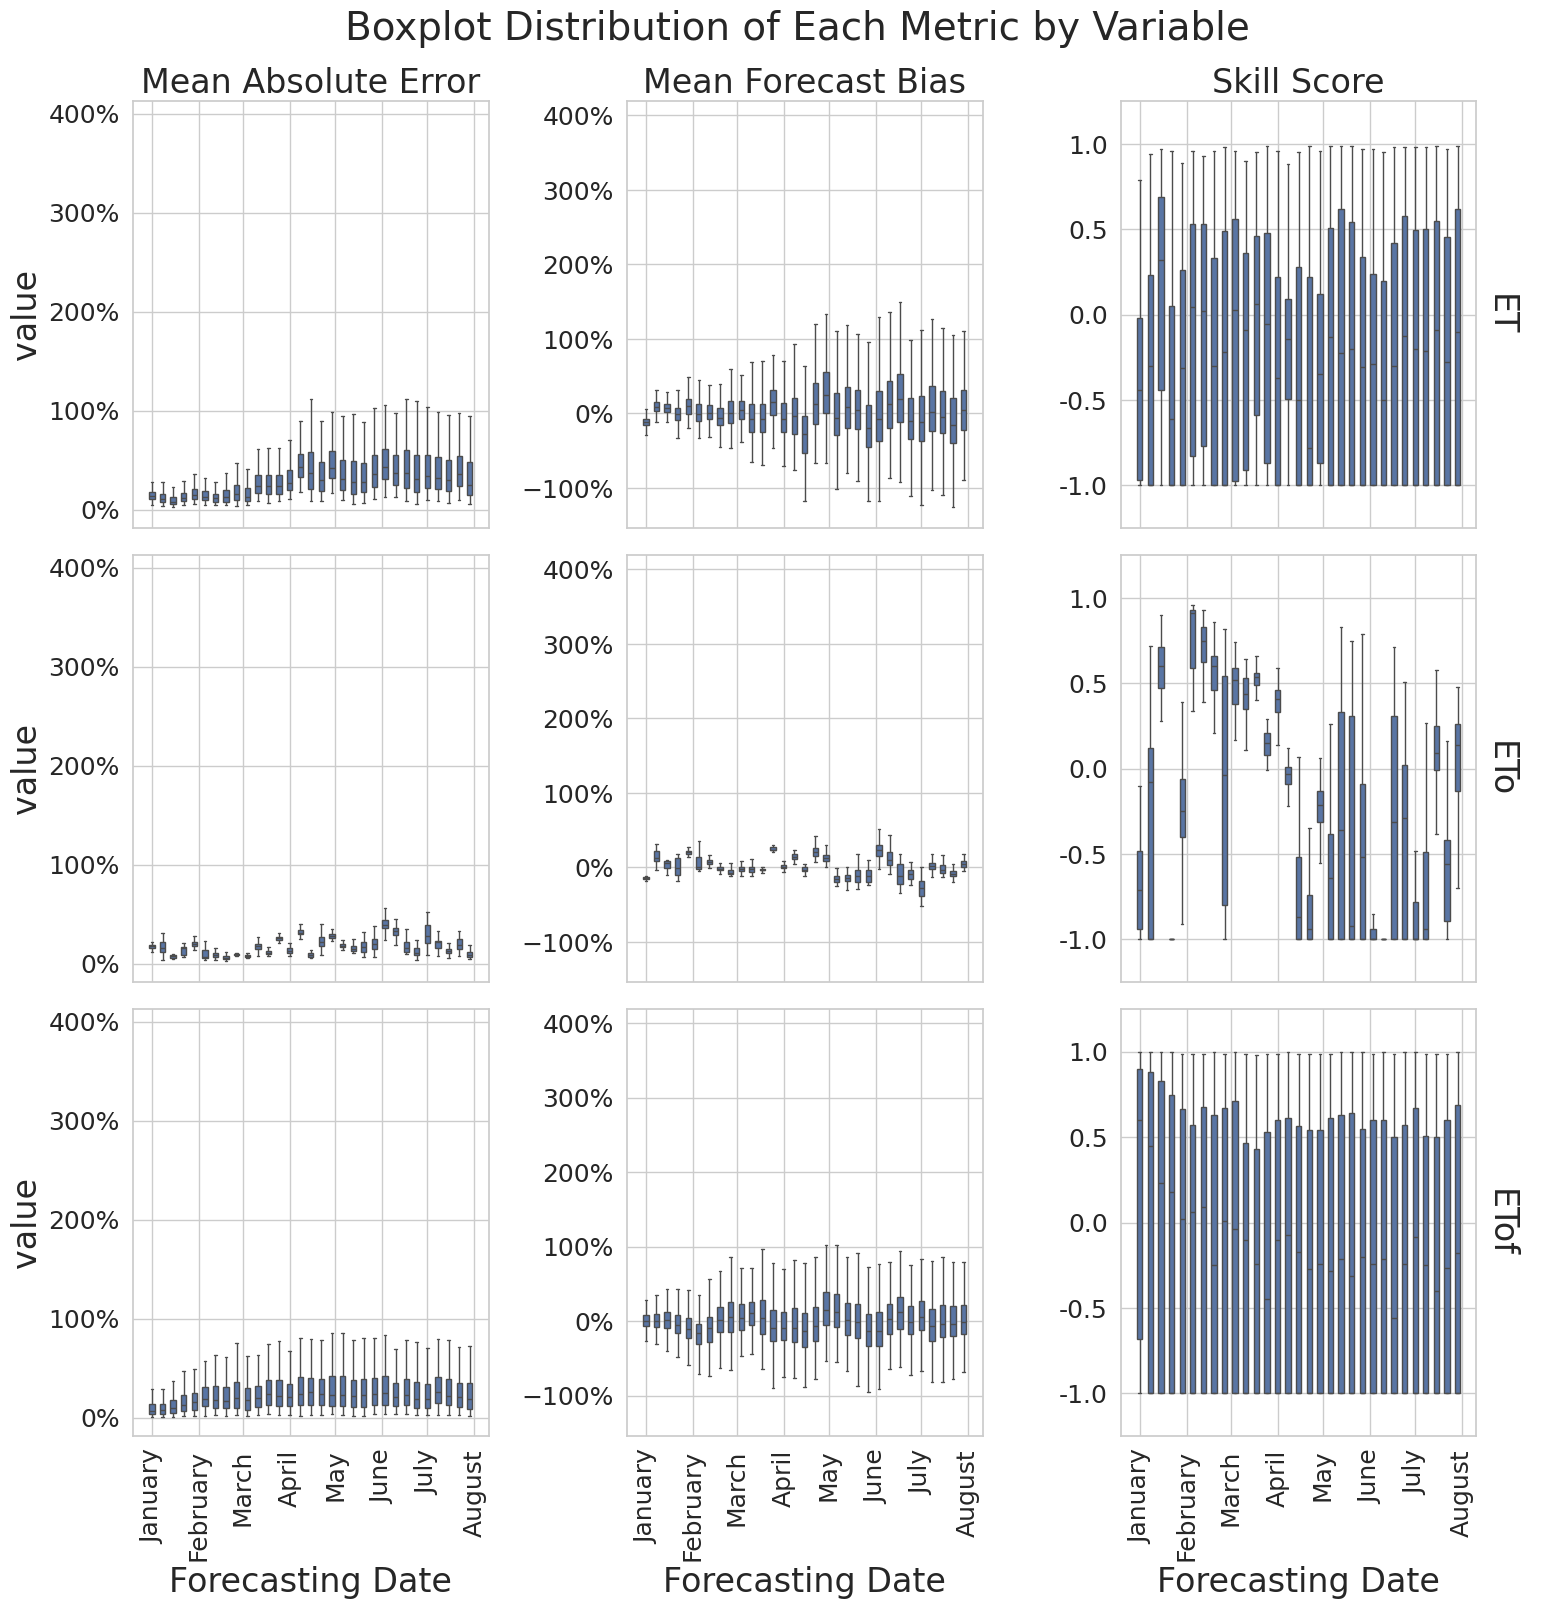

In [151]:
rel = timeseries_rel(data=metrics_long, plot='cat', kind='box',
                y='value', col='name', row='variable',
                width=0.5, errorbar='sd',
                flierprops=dict(markersize=0), title="Boxplot Distribution of Each Metric by Variable",
                export_img='field_boxplots.png', as_percent=True, margin_titles=True,
                row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                facet_kws={"despine": False}, sharey='col', native_scale=True
               );
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('images/monterey/field_boxplots.png')

##### Metric Distrbution by Standard Deviation

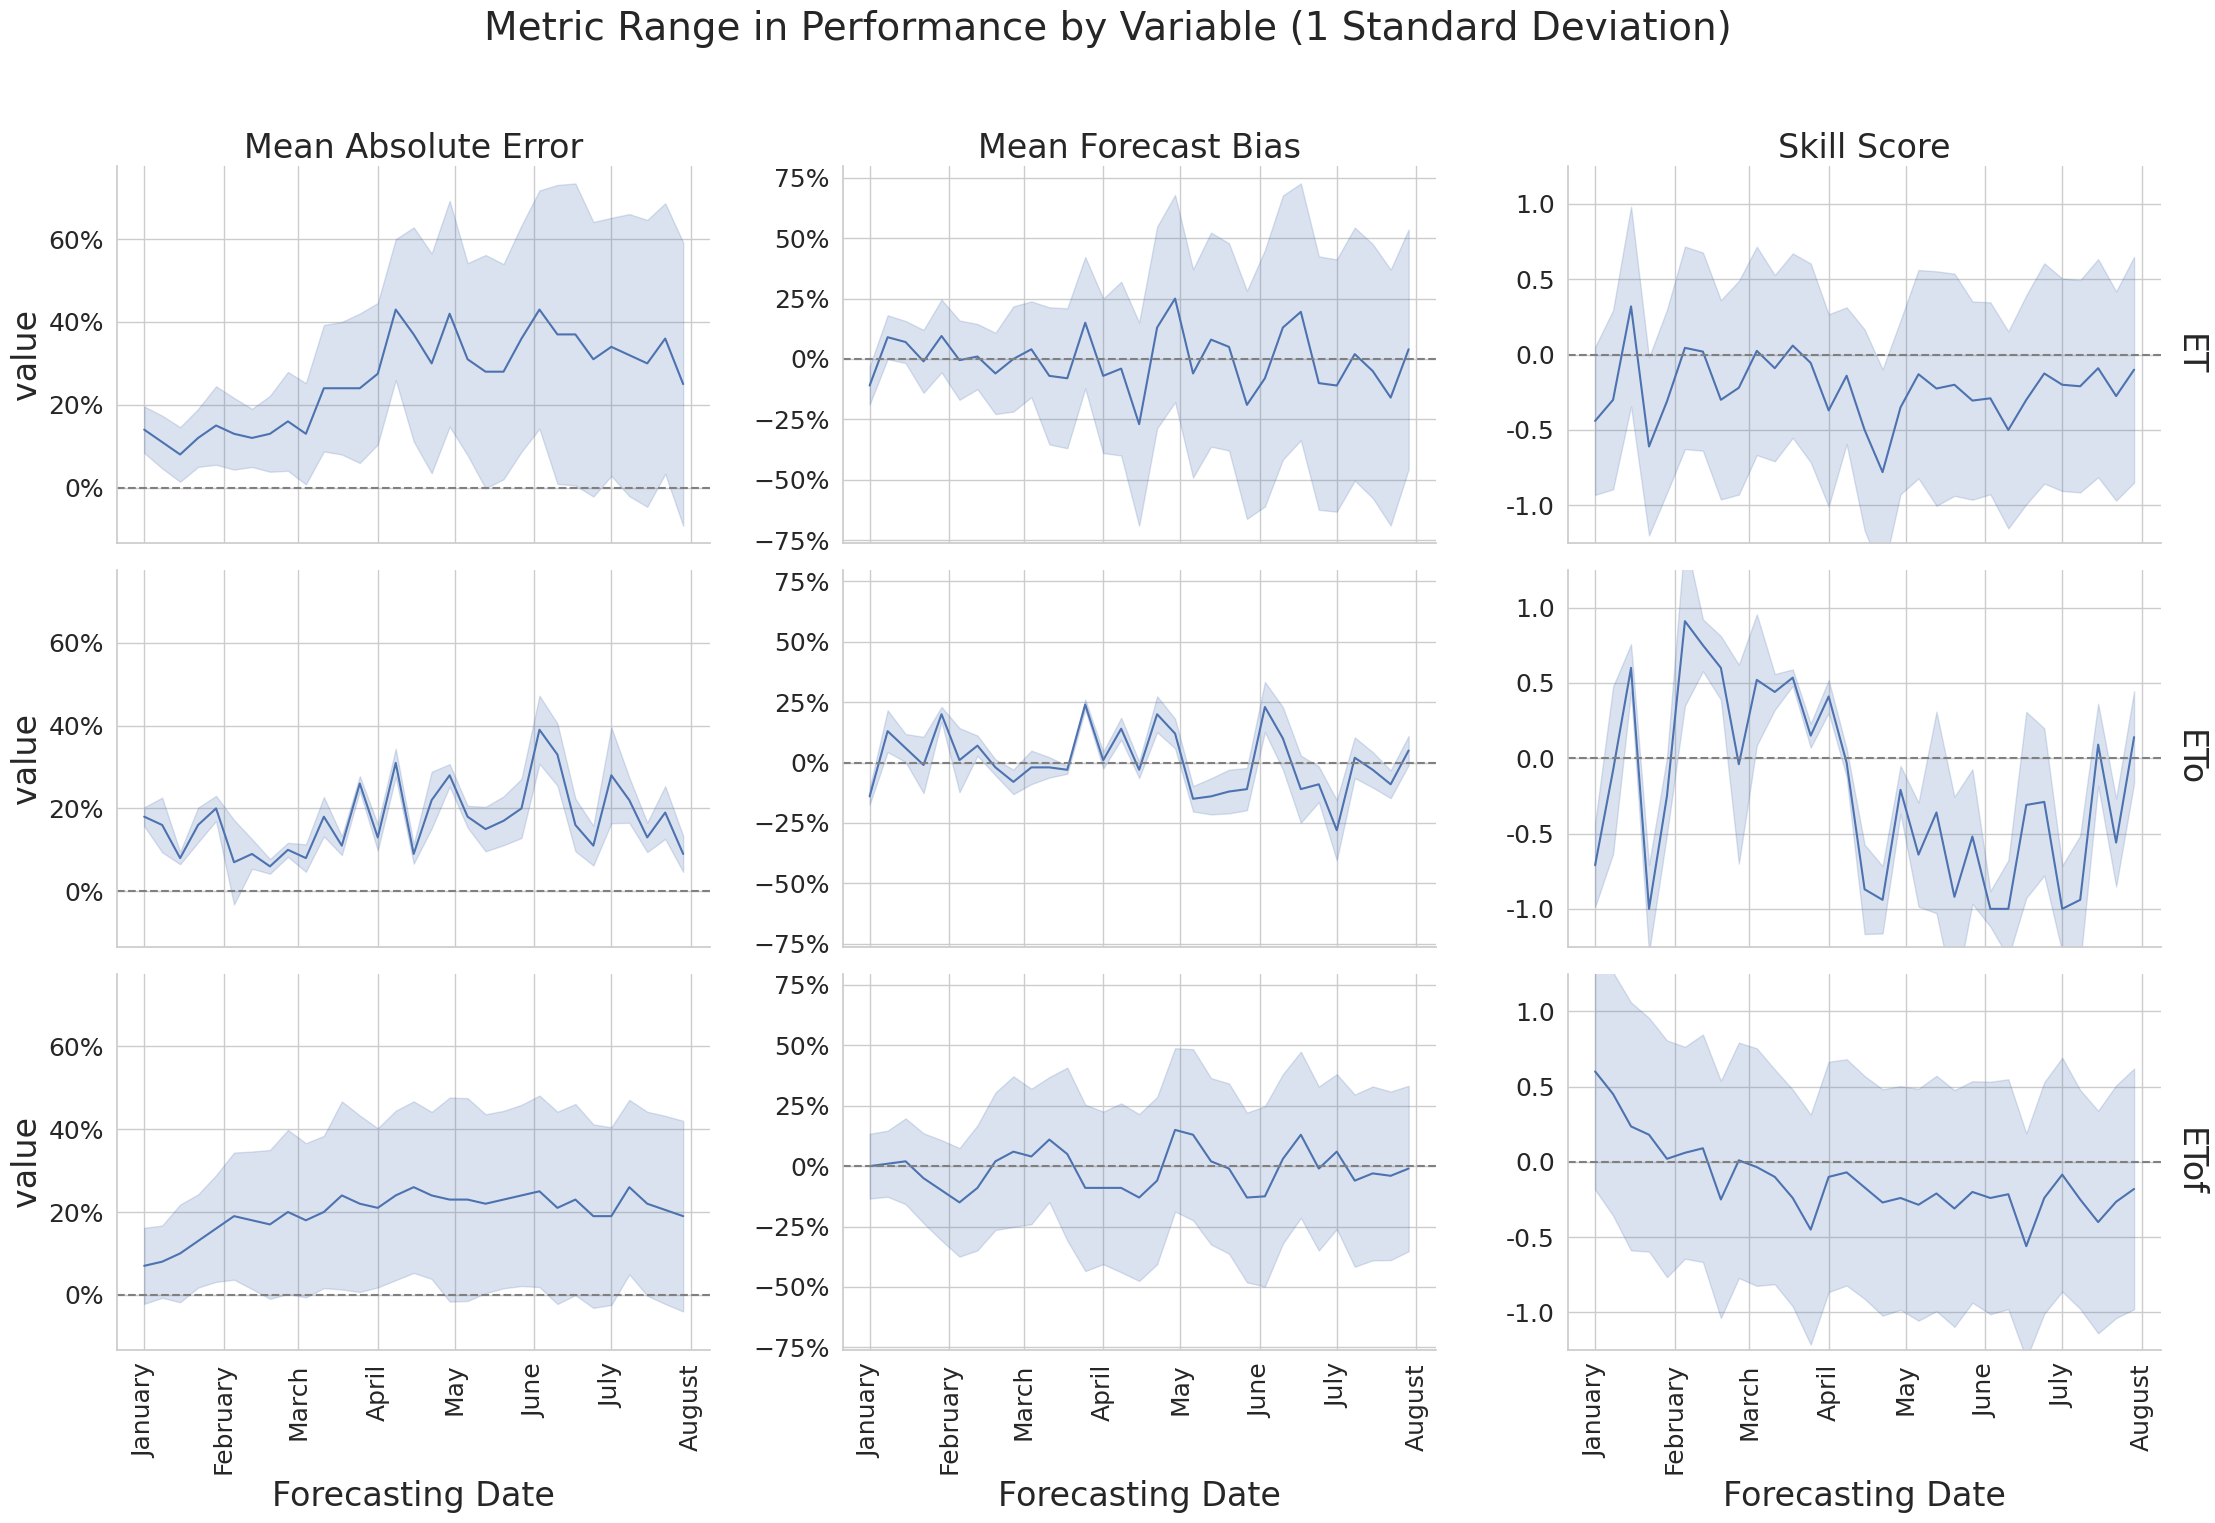

In [152]:
rel = timeseries_rel(metrics_long, row='variable', col='name', y='value',
                     errorbar='sd', estimator=np.median, as_percent=True,
                     refline={'y': 0},
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True}, aspect=1.5,
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Metric Range in Performance by Variable (1 Standard Deviation)");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('images/monterey/field_metric_range_sd.png')

#### Crop Metrics

In [153]:
# Reappend class names of crops for better readability in plots.
metrics_long = metrics_long.join(cdl_codes, how="left", on="crop", validate="many_to_many")

In [154]:
# crop_selector = dt.groupby('crop')['hectares'].agg('sum')[:3]
crop_selector = [47, 69]

In [155]:
dt[dt['crop'].isin(crop_selector)].groupby('crop')['field_id'].nunique()

crop
47    513
69    136
Name: field_id, dtype: int64

In [156]:
crop_plotter = metrics_long[metrics_long['crop'].isin(crop_selector)]
crop_plotter.head()

forecasting_date   field_id  crop variable stat  value                 name  \
0       2024-01-01  CA_244000    47       ET  mae   0.12  Mean Absolute Error   
1       2024-01-01  CA_244018    47       ET  mae   0.11  Mean Absolute Error   
2       2024-01-01  CA_244025    47       ET  mae   0.17  Mean Absolute Error   
3       2024-01-01  CA_244035    69       ET  mae   0.10  Mean Absolute Error   
4       2024-01-01  CA_244053    47       ET  mae   0.21  Mean Absolute Error   

          Class_Names  ESRI_Red  ESRI_Green  ESRI_Blue  Erdas_Red  \
0  Misc Vegs & Fruits       255         102        102     1.0000   
1  Misc Vegs & Fruits       255         102        102     1.0000   
2  Misc Vegs & Fruits       255         102        102     1.0000   
3              Grapes       112          68        137     0.4392   
4  Misc Vegs & Fruits       255         102        102     1.0000   

   Erdas_Green  Erdas_Blue  
0       0.4000      0.4000  
1       0.4000      0.4000  
2       0.4000      0.4000  
3       0.2667      0.5373  
4       0.4000      0.4000

##### Probability Distributions

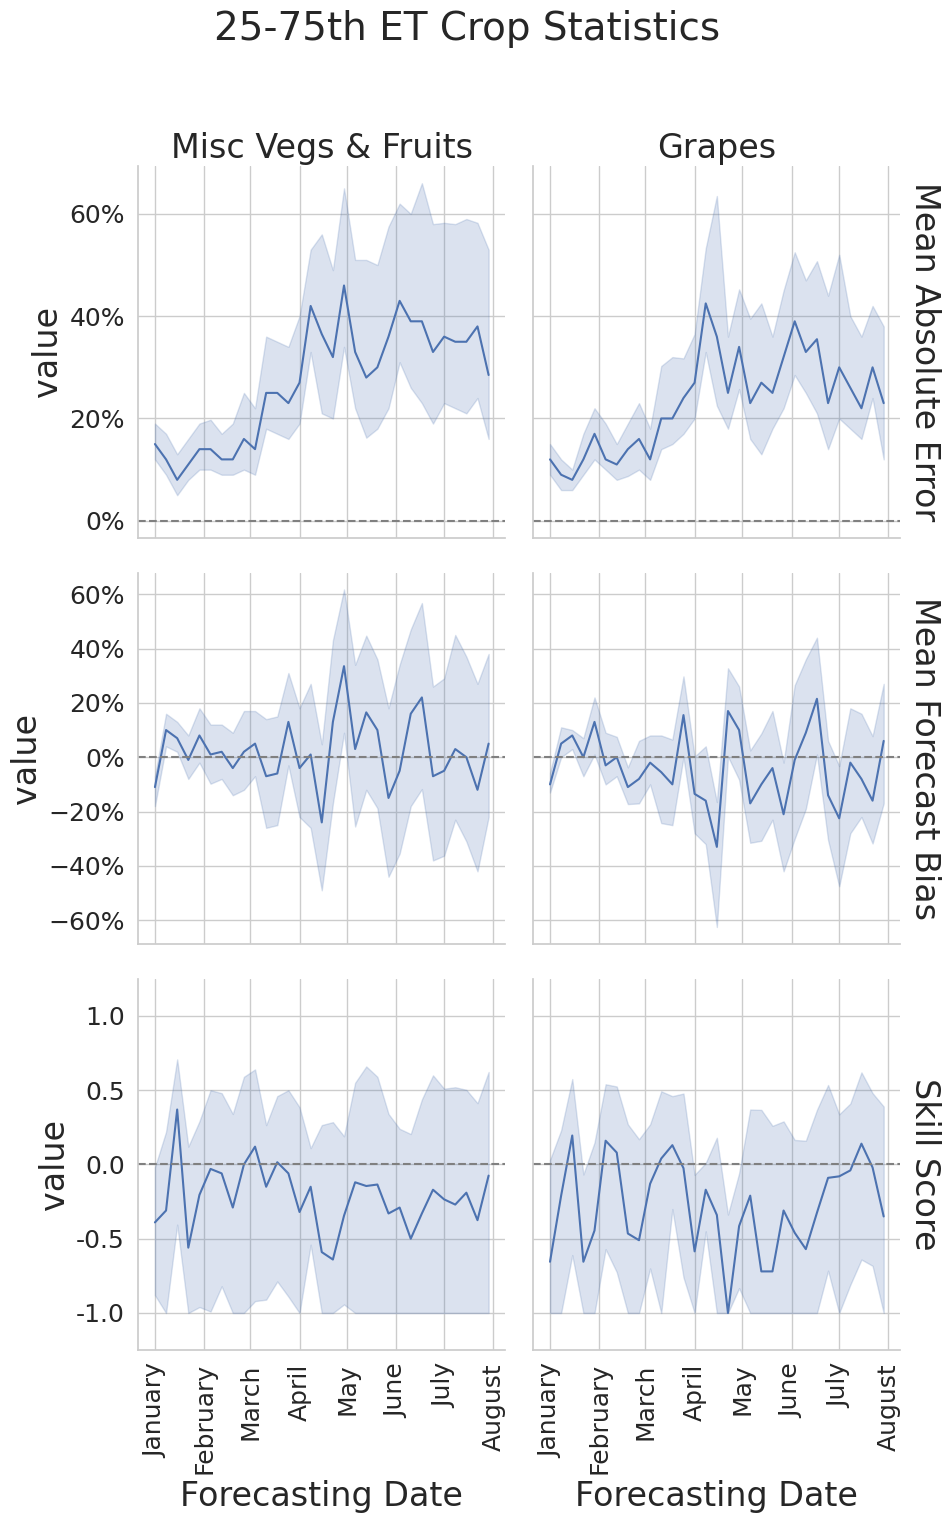

In [157]:
rel = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ET'], y='value', plot='rel', kind='line',
                        col='Class_Names', row='name',
                        refline={'y': 0},
                        facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True}, 
                        estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                        title='25-75th ET Crop Statistics', as_percent=True);
rel.axes.flat[4].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[4].set(ylim=(-1.25, 1.25));
rel.axes.flat[4].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("images/monterey/et_crop_stats.png")

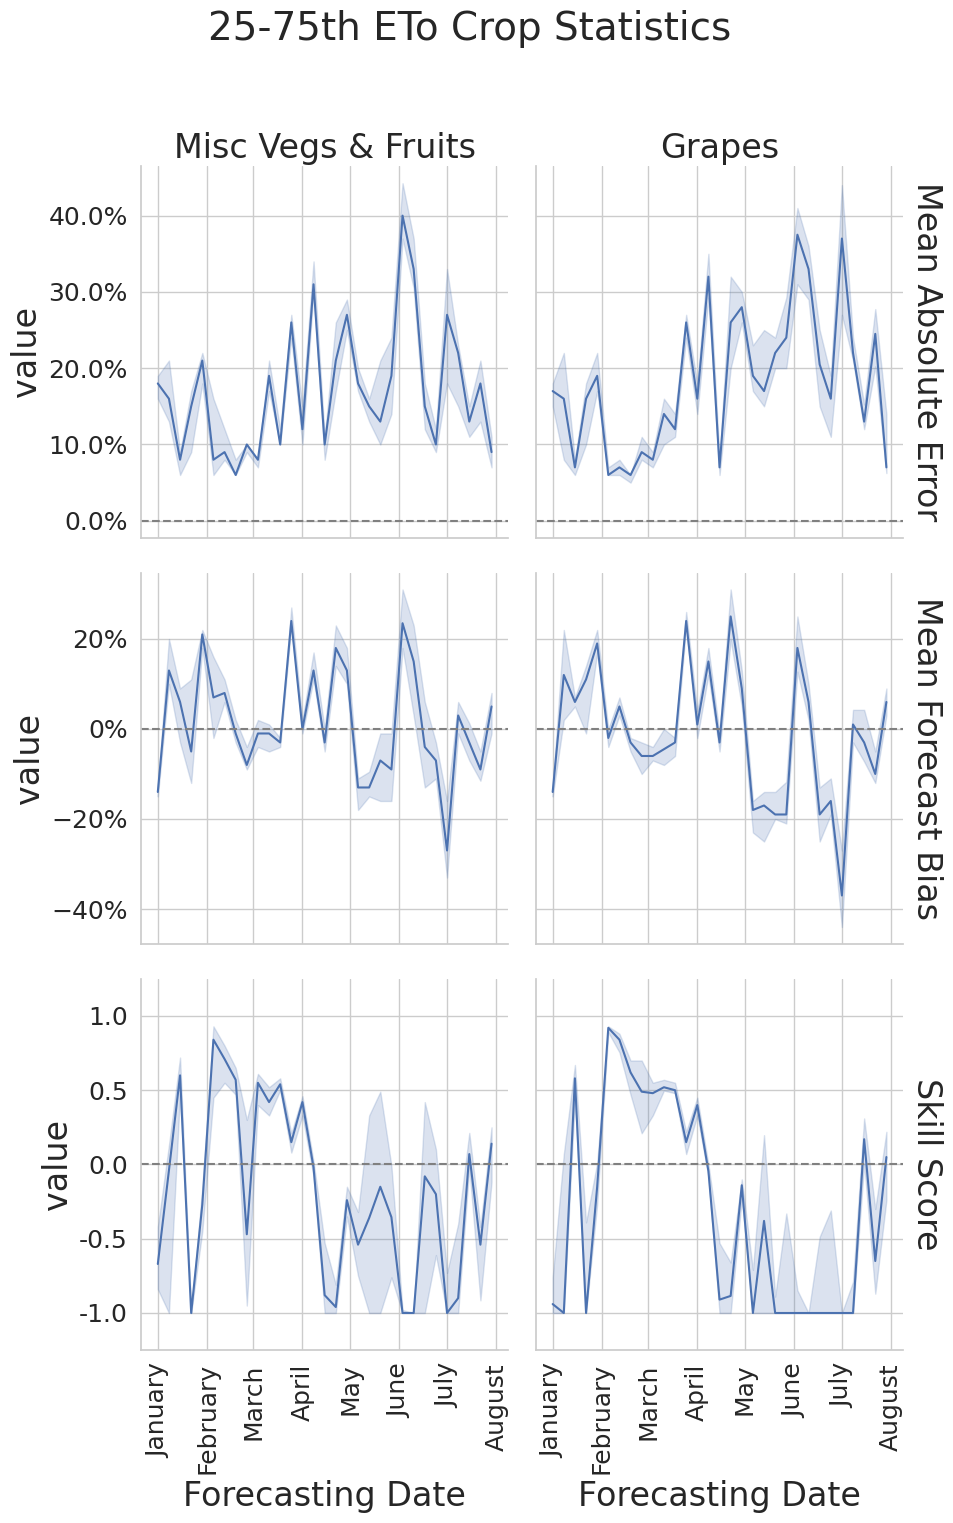

In [158]:
rel = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ETo'], y='value', plot='rel', kind='line', errorbar=('pi', 50),
                            col='Class_Names', row='name', facet_kws={'sharey': 'row', 'sharex': True, "margin_titles": True}, 
                            refline={'y': 0},
                            estimator=np.median, export_img="eto_crop_stats", title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                            title='25-75th ETo Crop Statistics', as_percent=True);
rel.axes.flat[4].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[4].set(ylim=(-1.25, 1.25));
rel.axes.flat[4].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("images/monterey/eto_crop_stats.png")

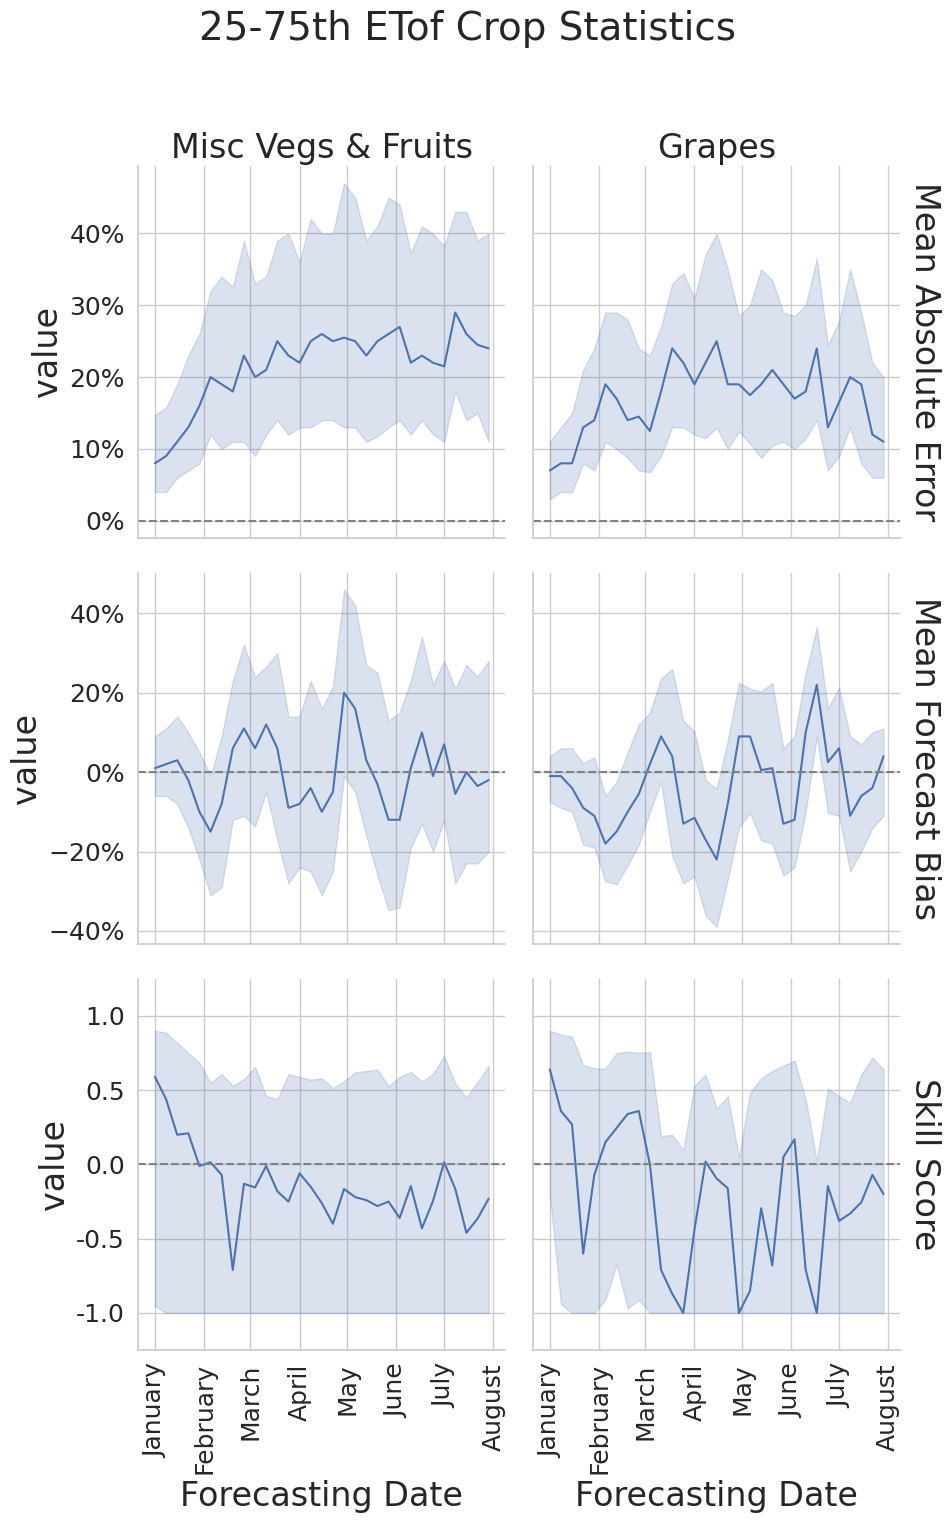

In [159]:
rel = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ETof'], y='value', plot='rel', kind='line', errorbar=('pi', 50),
                            col='Class_Names', row='name', facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True},
                            refline={'y': 0},
                            estimator=np.median, export_img="etof_crop_metrics", title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                            title='25-75th ETof Crop Statistics', as_percent=True);
rel.axes.flat[4].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[4].set(ylim=(-1.25, 1.25));
rel.axes.flat[4].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("images/monterey/etof_crop_stats.png")

### Alignment

In [160]:
df = dt[(dt['time'] >= dt['forecasting_date']) & (dt['time'] < (dt['forecasting_date']) + timedelta(days=7)) & (dt['time'] < analysis_end_date)]
df = df.sort_values(by=['forecasting_date', 'field_id'])
df.head()

forecasting_date   field_id  crop       time  actual_et  actual_eto  \
1081896       2024-01-01  CA_244000    47 2024-01-01      0.718       1.103   
1081897       2024-01-01  CA_244000    47 2024-01-02      0.668       1.018   
1081898       2024-01-01  CA_244000    47 2024-01-03      1.403       2.122   
1081899       2024-01-01  CA_244000    47 2024-01-04      1.698       2.546   
1081900       2024-01-01  CA_244000    47 2024-01-05      1.027       1.528   

         actual_etof  expected_et  expected_eto  expected_etof  longitude  \
1081896        0.650        0.718         1.103          0.650 -121.54054   
1081897        0.656        0.778         1.341          0.640 -121.54054   
1081898        0.661        0.792         1.386          0.639 -121.54054   
1081899        0.667        0.847         1.394          0.638 -121.54054   
1081900        0.672        0.951         1.379          0.636 -121.54054   

          latitude         Class_Names  ESRI_Red  ESRI_Green  ESRI_Blue  \
1081896  36.537255  Misc Vegs & Fruits       255         102        102   
1081897  36.537255  Misc Vegs & Fruits       255         102        102   
1081898  36.537255  Misc Vegs & Fruits       255         102        102   
1081899  36.537255  Misc Vegs & Fruits       255         102        102   
1081900  36.537255  Misc Vegs & Fruits       255         102        102   

         Erdas_Red  Erdas_Green  Erdas_Blue  hectares  
1081896        1.0          0.4         0.4   263.816  
1081897        1.0          0.4         0.4   263.816  
1081898        1.0          0.4         0.4   263.816  
1081899        1.0          0.4         0.4   263.816  
1081900        1.0          0.4         0.4   263.816

In [161]:
def align_forecast(data: pd.DataFrame, adjustment=0.9):
    recorded_et = data.head(1)['actual_et'].values[0]
    recorded_eto = data.head(1)['actual_eto'].values[0]
    recorded_etof = data.head(1)['actual_etof'].values[0]

    first_et = data.head(1)['expected_et'].values[0]
    first_eto = data.head(1)['expected_eto'].values[0]
    first_etof = data.head(1)['expected_etof'].values[0]
    
    # last_obs: 0.543
    # first_f: 0.750
    # calc = (0.750 - 0.543) * 0.9 = 0.207 * 0.9 = 0.1863
    
    # get the difference of just the first forecasted date and apply it to the rest of the forecasting period
    data['expected_et'] = data['expected_et'] - (first_et - recorded_et)
    data['expected_eto'] = data['expected_eto'] - (first_eto - recorded_eto)
    data['expected_etof'] = data['expected_etof'] - (first_etof - recorded_etof)

    return data[['field_id', 'crop', 'time', 'actual_et', 'actual_eto', 'actual_etof', 'expected_et', 'expected_eto', 'expected_etof', 'Class_Names', 'ESRI_Red', 'ESRI_Green', 'ESRI_Blue', 'Erdas_Red', 'Erdas_Green', 'Erdas_Blue', 'hectares']]

In [162]:
df = df.groupby('forecasting_date')[list(df.columns)].apply(align_forecast).reset_index().drop(columns='level_1')
df.head()

forecasting_date   field_id  crop       time  actual_et  actual_eto  \
0       2024-01-01  CA_244000    47 2024-01-01      0.718       1.103   
1       2024-01-01  CA_244000    47 2024-01-02      0.668       1.018   
2       2024-01-01  CA_244000    47 2024-01-03      1.403       2.122   
3       2024-01-01  CA_244000    47 2024-01-04      1.698       2.546   
4       2024-01-01  CA_244000    47 2024-01-05      1.027       1.528   

   actual_etof  expected_et  expected_eto  expected_etof         Class_Names  \
0        0.650        0.718         1.103          0.650  Misc Vegs & Fruits   
1        0.656        0.778         1.341          0.640  Misc Vegs & Fruits   
2        0.661        0.792         1.386          0.639  Misc Vegs & Fruits   
3        0.667        0.847         1.394          0.638  Misc Vegs & Fruits   
4        0.672        0.951         1.379          0.636  Misc Vegs & Fruits   

   ESRI_Red  ESRI_Green  ESRI_Blue  Erdas_Red  Erdas_Green  Erdas_Blue  \
0       255         102        102        1.0          0.4         0.4   
1       255         102        102        1.0          0.4         0.4   
2       255         102        102        1.0          0.4         0.4   
3       255         102        102        1.0          0.4         0.4   
4       255         102        102        1.0          0.4         0.4   

   hectares  
0   263.816  
1   263.816  
2   263.816  
3   263.816  
4   263.816

#### Metric Calculation

In [163]:
# alignment_metrics = df.groupby('forecasting_date').apply(eval_metrics, normalize=True, climatology_ref=climatology_table, avgs_ref=avgs_table)
# alignment_metrics.reset_index().to_csv('./data/metrics/monterey_alignment_metrics.csv', index=False)
# alignment_metrics.head()

In [164]:
alignment_metrics = pd.read_csv('./data/metrics/monterey_alignment_metrics.csv', low_memory=False).drop(columns='level_1')
alignment_metrics['forecasting_date'] = pd.to_datetime(alignment_metrics['forecasting_date'])
alignment_metrics.head()

forecasting_date   field_id  crop   mae  rmse  corr  bias  skill_score  \
0       2024-01-01  CA_244000    47  0.04  0.04 -0.94 -0.04        -0.35   
1       2024-01-01  CA_244018    47  0.09  0.08 -0.97  0.09         0.66   
2       2024-01-01  CA_244025    47  0.18  0.16 -0.85  0.18        -1.00   
3       2024-01-01  CA_244035    69  0.03  0.02  0.97  0.03         0.95   
4       2024-01-01  CA_244053    47  0.12  0.09 -0.71  0.12        -0.12   

  variable  
0     ETof  
1     ETof  
2     ETof  
3     ETof  
4     ETof

#### Visualization

In [165]:
alignment_metrics_long = alignment_metrics.reset_index().melt(
    id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')
alignment_metrics_long.join(cdl_codes, how="left", on="crop", validate="many_to_many")
alignment_metrics_long

forecasting_date   field_id  crop variable         stat  value
0            2024-01-01  CA_244000    47     ETof          mae   0.04
1            2024-01-01  CA_244018    47     ETof          mae   0.09
2            2024-01-01  CA_244025    47     ETof          mae   0.18
3            2024-01-01  CA_244035    69     ETof          mae   0.03
4            2024-01-01  CA_244053    47     ETof          mae   0.12
...                 ...        ...   ...      ...          ...    ...
206176       2024-07-29  CA_420824    72       ET  skill_score  -1.00
206177       2024-07-29  CA_420843    47       ET  skill_score  -0.81
206178       2024-07-29  CA_420876   215       ET  skill_score   0.55
206179       2024-07-29  CA_420910   211       ET  skill_score   0.94
206180       2024-07-29  CA_420924    68       ET  skill_score  -0.77

[206181 rows x 6 columns]

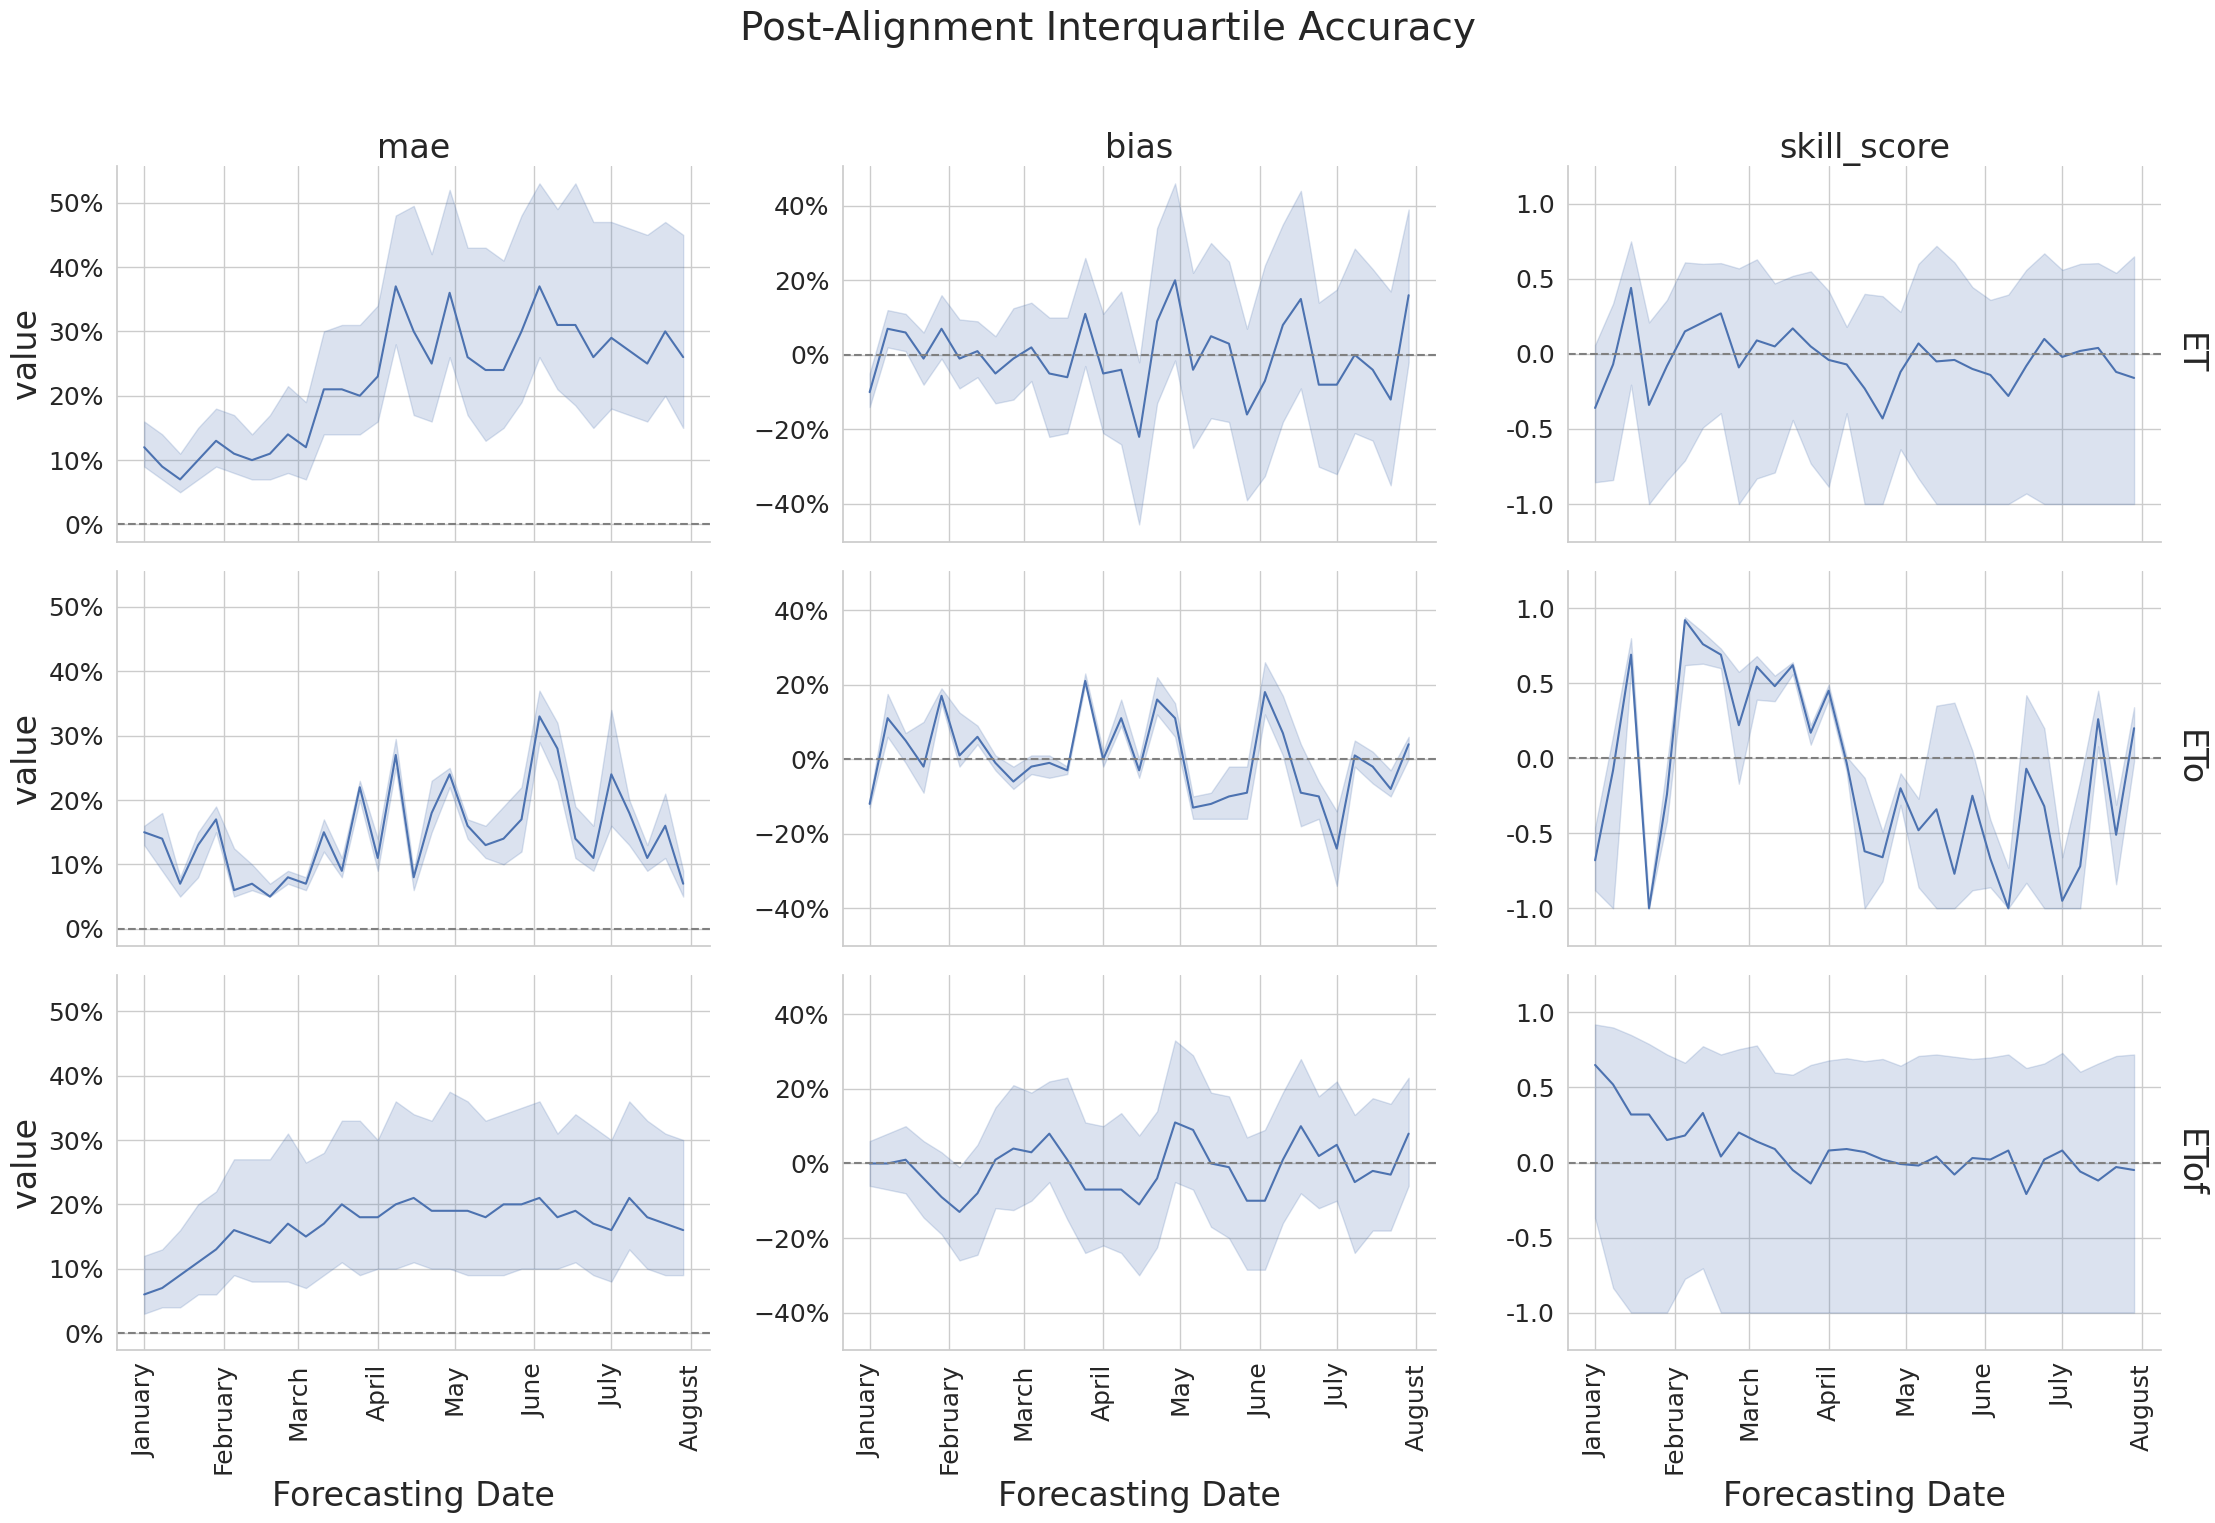

In [166]:
rel = timeseries_rel(alignment_metrics_long, row='variable', col='stat', y='value',
                     errorbar=('pi', 50), estimator=np.median, as_percent=True, aspect=1.5,
                     refline={'y': 0},
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True},
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Post-Alignment Interquartile Accuracy");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[5].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[5].set(ylim=(-1.25, 1.25));
rel.axes.flat[5].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[8].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[8].set(ylim=(-1.25, 1.25));
rel.axes.flat[8].set_yticks((1, 0.5, 0, -0.5, -1));

#### Alignment Comparison

In [167]:
alignment_metrics_long['aligned'] = True
metrics_long['aligned'] = False

alignment_metrics_cmp = pd.concat([alignment_metrics_long, metrics_long])
alignment_metrics_cmp

forecasting_date   field_id  crop variable         stat  value  \
0            2024-01-01  CA_244000    47     ETof          mae   0.04   
1            2024-01-01  CA_244018    47     ETof          mae   0.09   
2            2024-01-01  CA_244025    47     ETof          mae   0.18   
3            2024-01-01  CA_244035    69     ETof          mae   0.03   
4            2024-01-01  CA_244053    47     ETof          mae   0.12   
...                 ...        ...   ...      ...          ...    ...   
191512       2024-07-29  CA_420824    72     ETof  skill_score   0.80   
191513       2024-07-29  CA_420843    47     ETof  skill_score   0.08   
191514       2024-07-29  CA_420876   215     ETof  skill_score   0.64   
191515       2024-07-29  CA_420910   211     ETof  skill_score   0.98   
191516       2024-07-29  CA_420924    68     ETof  skill_score  -1.00   

        aligned         name         Class_Names  ESRI_Red  ESRI_Green  \
0          True          NaN                 NaN       NaN         NaN   
1          True          NaN                 NaN       NaN         NaN   
2          True          NaN                 NaN       NaN         NaN   
3          True          NaN                 NaN       NaN         NaN   
4          True          NaN                 NaN       NaN         NaN   
...         ...          ...                 ...       ...         ...   
191512    False  Skill Score              Citrus     255.0       255.0   
191513    False  Skill Score  Misc Vegs & Fruits     255.0       102.0   
191514    False  Skill Score            Avocados     102.0       153.0   
191515    False  Skill Score              Olives      52.0        74.0   
191516    False  Skill Score              Apples     185.0         0.0   

        ESRI_Blue  Erdas_Red  Erdas_Green  Erdas_Blue  
0             NaN        NaN          NaN         NaN  
1             NaN        NaN          NaN         NaN  
2             NaN        NaN          NaN         NaN  
3             NaN        NaN          NaN         NaN  
4             NaN        NaN          NaN         NaN  
...           ...        ...          ...         ...  
191512      128.0     1.0000       1.0000      0.4980  
191513      102.0     1.0000       0.4000      0.4000  
191514       77.0     0.4000       0.6000      0.3000  
191515       52.0     0.2000       0.2863      0.2000  
191516       80.0     0.7294       0.0000      0.3098  

[397698 rows x 15 columns]

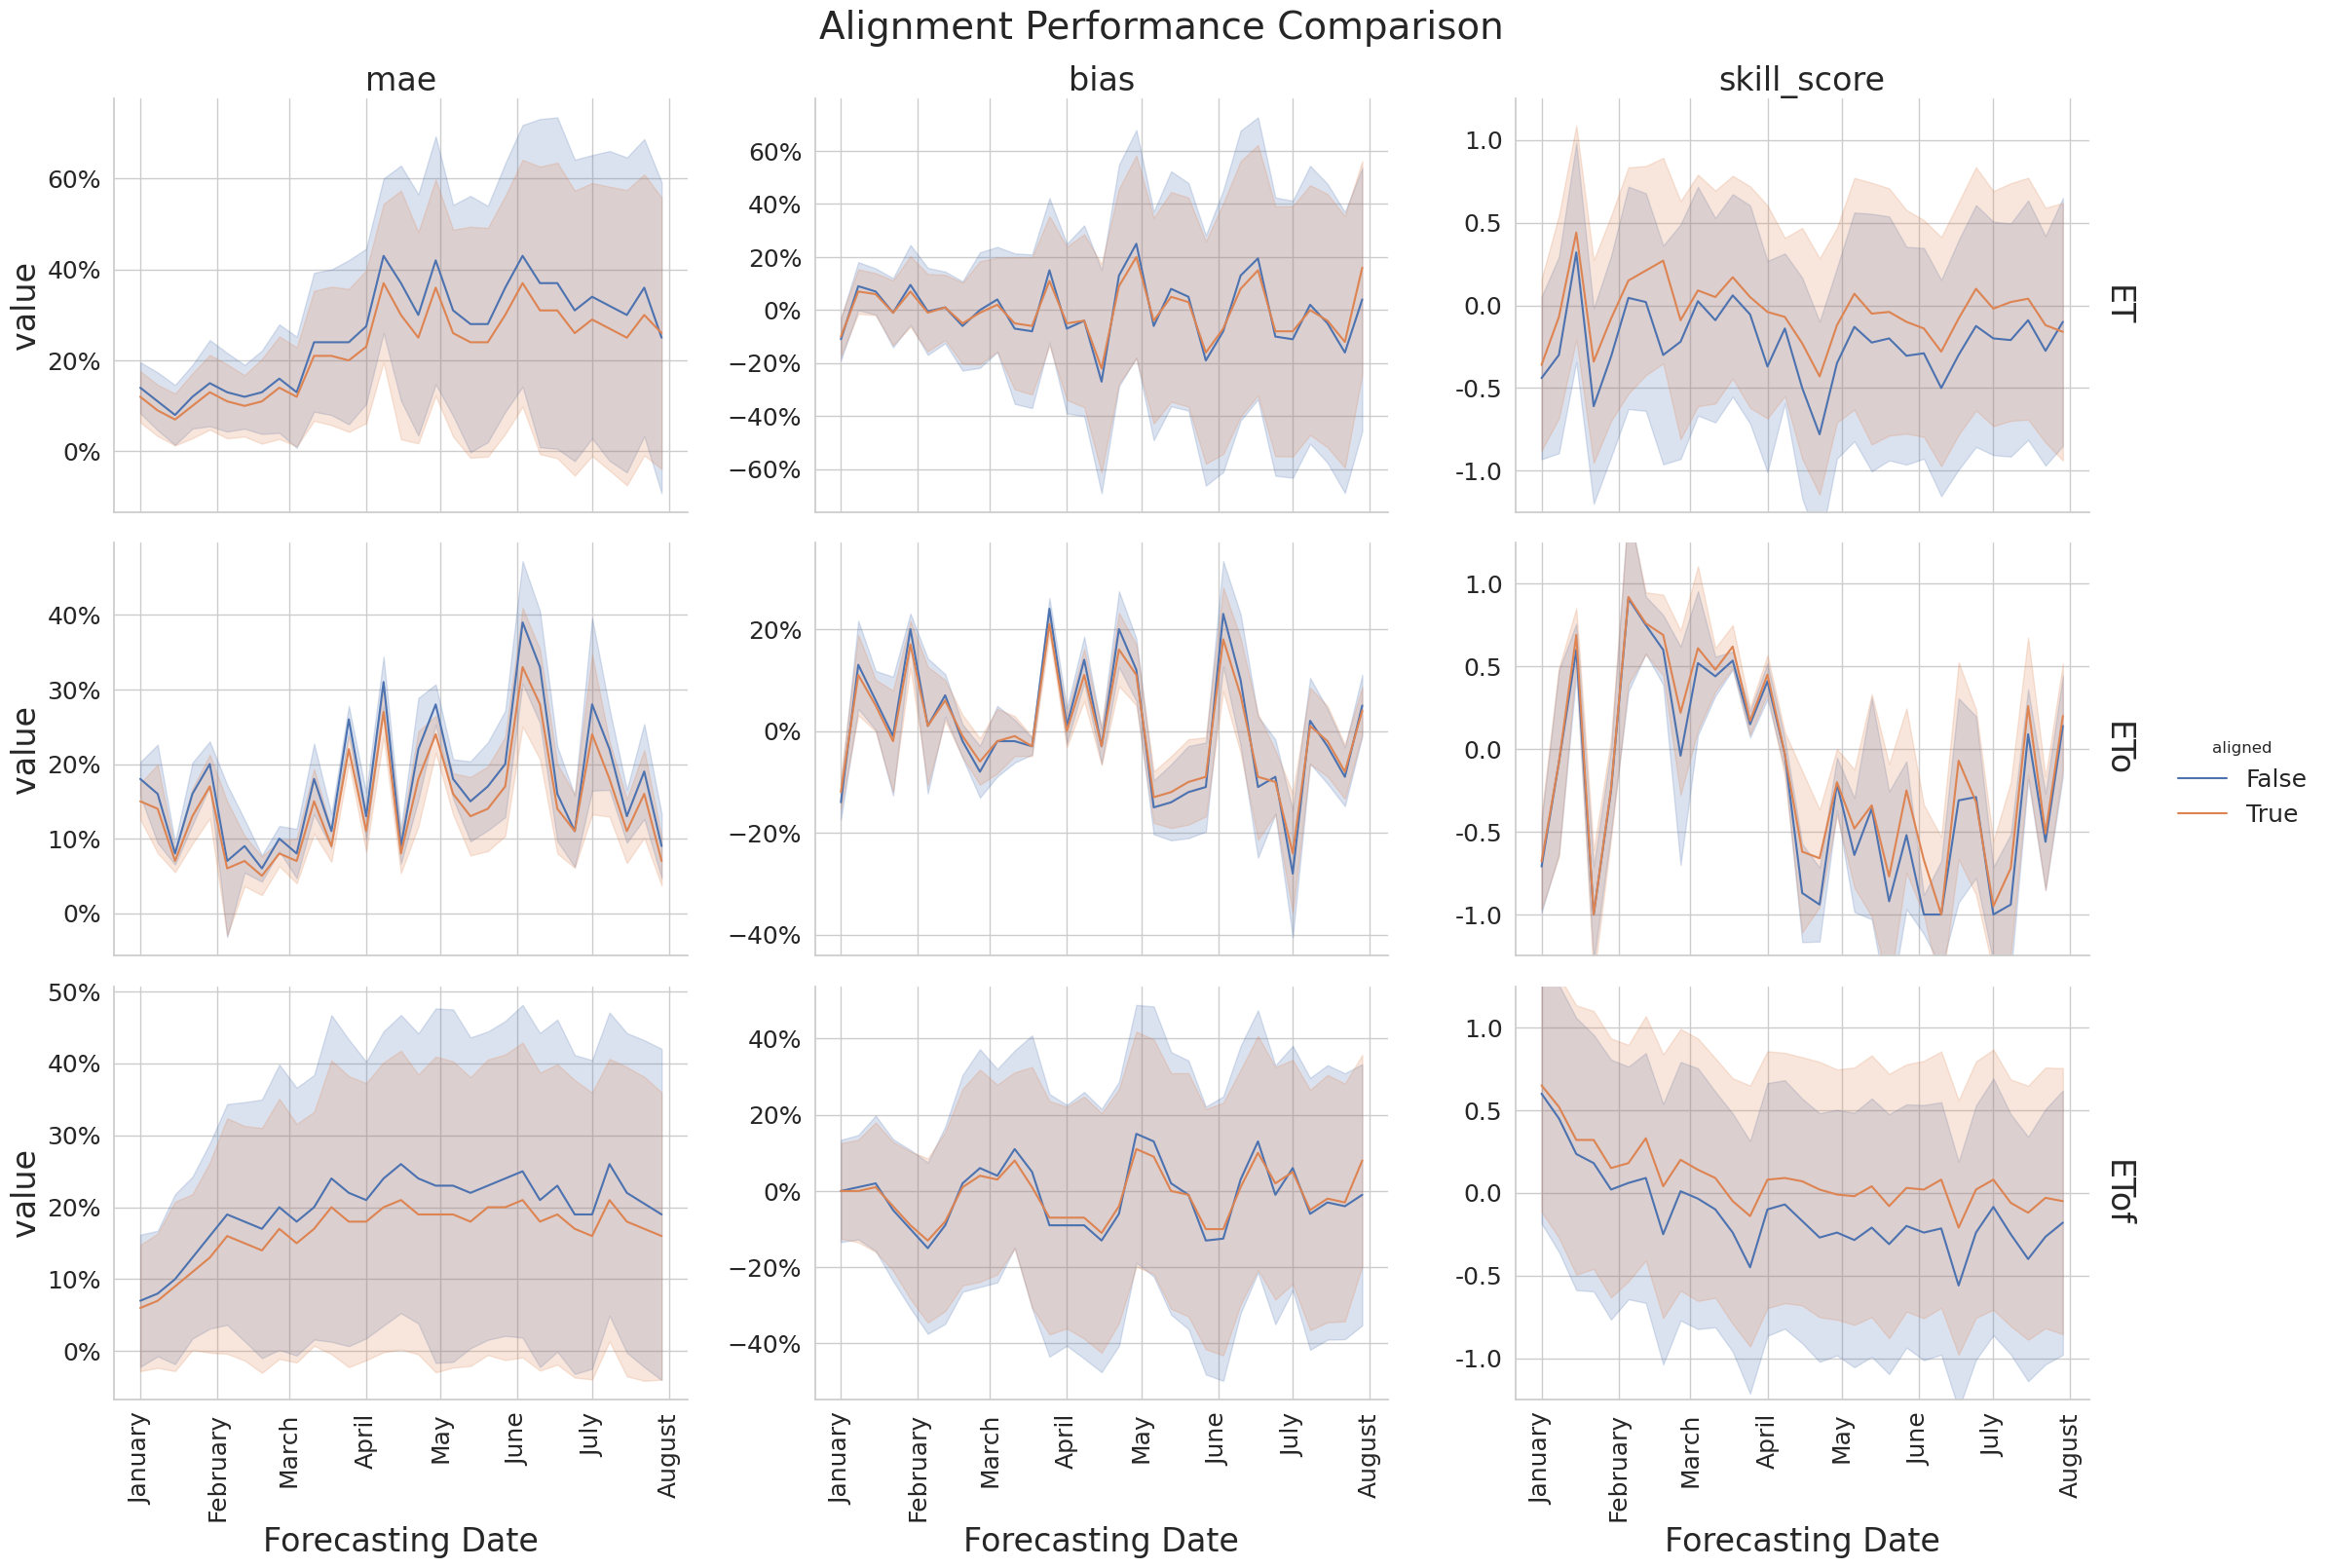

In [168]:
rel = timeseries_rel(alignment_metrics_cmp, row='variable', col='stat', y='value', hue='aligned',
                     errorbar='sd', estimator=np.median, as_percent=True, aspect=1.5,
                     facet_kws={'sharey': False, 'sharex': True, 'margin_titles': True},
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Alignment Performance Comparison");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[5].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[5].set(ylim=(-1.25, 1.25));
rel.axes.flat[5].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[8].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[8].set(ylim=(-1.25, 1.25));
rel.axes.flat[8].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('./images/monterey/alignment_comparison.png')

### Spatial Plotting

#### Preparation

First merge the geo table created in the beginning with the metrics table.

Afterwards, get the average metrics amongst all forecasts.

In [169]:
# Define date range of seasons
winter = (datetime(year=2024, month=1, day=1), datetime(year=2024, month=3, day=20)) # Start winter at start of forecast range
spring = (datetime(year=2024, month=3, day=21), datetime(year=2024, month=6, day=20))
summer = (datetime(year=2024, month=6, day=21), datetime(year=2024, month=9, day=20))

# Create list of the forecast dates that fit the seasonal ranges
winter_forecasts = pd.Series([x for x in forecast_dates if x >= winter[0] and x <= winter[1]])
spring_forecasts = pd.Series([x for x in forecast_dates if x >= spring[0] and x <= spring[1]])
summer_forecasts = pd.Series([x for x in forecast_dates if x >= summer[0] and x <= summer[1]])

def assign_season(x):
    season = ""
    if winter_forecasts.isin([x['forecasting_date']]).any():
        season = "Winter"
    elif spring_forecasts.isin([x['forecasting_date']]).any():
        season = "Spring"
    elif summer_forecasts.isin([x['forecasting_date']]).any():
        season = "Summer"
    return pd.Series({'season': season})

In [170]:
# Create column that defines a row's season
seasonal_metrics = metrics_norm.reset_index().sort_values(by='forecasting_date').merge(metrics_norm.reset_index().apply(assign_season, axis=1), left_index=True, right_index=True)

# Combine all forecasts for each field by getting mean of forecast metrics.
seasonal_metrics = seasonal_metrics.groupby(['field_id', 'season', 'variable'])[['mae', 'rmse', 'bias', 'corr', 'skill_score']].agg('mean').round(2)

# Add positional columns
seasonal_metrics = seasonal_metrics.join(monterey_geo, how='left', on='field_id', validate='many_to_one')
# Add field size column for marker size
seasonal_metrics = seasonal_metrics.join(field_metadata, how='left', on='field_id', validate='many_to_one')
# Calculate marker size
seasonal_metrics['markersize'] = seasonal_metrics.apply(lambda x: np.max(np.divmod(x['hectares'] / 10, 10)[1], initial=2.0), axis=1)

seasonal_metrics.reset_index(inplace=True)
seasonal_metrics.dropna(inplace=True)
seasonal_metrics

field_id  season variable   mae  rmse  bias  corr  skill_score  \
0     CA_244000  Spring       ET  0.26  0.49 -0.14 -0.00        -0.21   
1     CA_244000  Spring      ETo  0.17  0.40 -0.05 -0.25        -0.60   
2     CA_244000  Spring     ETof  0.17  0.15 -0.09  0.30        -0.29   
3     CA_244000  Summer       ET  0.64  1.12 -0.61 -0.06         0.12   
4     CA_244000  Summer      ETo  0.15  0.37 -0.08 -0.22        -0.29   
...         ...     ...      ...   ...   ...   ...   ...          ...   
6554  CA_258026  Summer      ETo  0.16  0.36 -0.08 -0.15        -0.34   
6555  CA_258026  Summer     ETof  0.08  0.08 -0.02 -0.36         0.26   
6556  CA_258026  Winter       ET  0.10  0.20 -0.04  0.25        -0.13   
6557  CA_258026  Winter      ETo  0.11  0.24 -0.00  0.20         0.15   
6558  CA_258026  Winter     ETof  0.12  0.11 -0.06 -0.22        -0.22   

       longitude   latitude  hectares  markersize  
0    -121.540540  36.537255   263.816      6.3816  
1    -121.540540  36.537255   263.816      6.3816  
2    -121.540540  36.537255   263.816      6.3816  
3    -121.540540  36.537255   263.816      6.3816  
4    -121.540540  36.537255   263.816      6.3816  
...          ...        ...       ...         ...  
6554 -121.485852  36.463501     7.117      2.0000  
6555 -121.485852  36.463501     7.117      2.0000  
6556 -121.485852  36.463501     7.117      2.0000  
6557 -121.485852  36.463501     7.117      2.0000  
6558 -121.485852  36.463501     7.117      2.0000  

[6558 rows x 12 columns]

#### Import regional polygon

In [171]:
moco_geo = gpd.read_file("./data/geo/MoCo_Boundary.geojson")
moco_geo

FID  PERIMETER       COUNTY    SHAPE_AREA     SHAPE_LEN  \
0    1    1903900  MONTEREY CO  9.239835e+10  2.155890e+06   

                                            geometry  
0  POLYGON ((-121.69858 36.9167, -121.70104 36.91...

#### FacetGrid Geo Helper

In [172]:
def facet_geoscatter(data, *, boundary_map, col, row=None, hue, palette="YlOrRd", size=8,
                     title, export_img: bool|str=None, height=4, aspect=1.2, double_legend=False,
                     row_order=None, col_order=None, title_template={}, as_percent=True,
                     normalize_cmap=False):
    g = sns.FacetGrid(data, col=col, row=row, height=height, aspect=aspect, despine=False, row_order=row_order, col_order=col_order)
    for ax in g.axes.flat:
     boundary_map.plot(color="lightgrey", ax=ax)

    norm = None
    
    if normalize_cmap:
        norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=data[hue].min(), vmax=data[hue].max())
        c_mappable = cm.ScalarMappable(norm=norm, cmap=palette)
        c_mappable.set_array(data[hue])
    else: 
        c_mappable = plt.scatter([], [], c=[], vmin=data[hue].min(), vmax=data[hue].max(), cmap=palette);

    g.map_dataframe(sns.scatterplot, x="longitude", y="latitude", hue=hue, hue_norm=norm, palette=palette, linewidths=0, size=size);
    g.tick_params(axis='x', rotation=90)
    g.set_titles(**title_template)
    plt.suptitle(title, y=1.02);

    g.figure.subplots_adjust(right=.92)
    cax = g.fig.add_axes([.94, .25, .02, .6])
    g.figure.colorbar(c_mappable, cax=cax)
    if as_percent:
        cax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    if double_legend is not False:
        g.figure.subplots_adjust(right=.90)
        dax = cax.twinx()
        if type(double_legend) is not bool:
            dax.set(ylim=(double_legend.min()['value'], double_legend.max()['value']))

    if type(export_img) is bool and save is True: g.savefig(f'images/monterey/{title}.png')
    elif type(export_img) is str: g.savefig(f'images/monterey/{export_img}.png')
    
    return g

In [173]:
plt.rcdefaults()

#### Seasonal Overview

##### ET Visualization

In [174]:
et_seasonal = seasonal_metrics[seasonal_metrics['variable'] == 'ET']

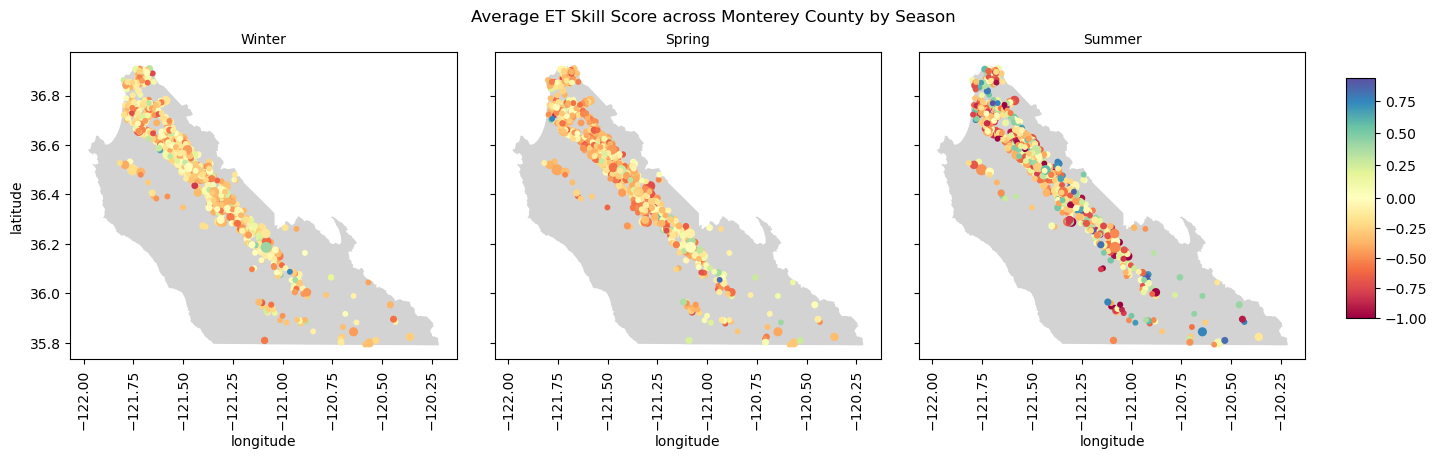

In [175]:
facet_geoscatter(et_seasonal, boundary_map=moco_geo, col='season', hue='skill_score', palette='Spectral', size='markersize',
                 as_percent=False, normalize_cmap=True, export_img="et_spatial_skill_score", 
                 col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                 title="Average ET Skill Score across Monterey County by Season");

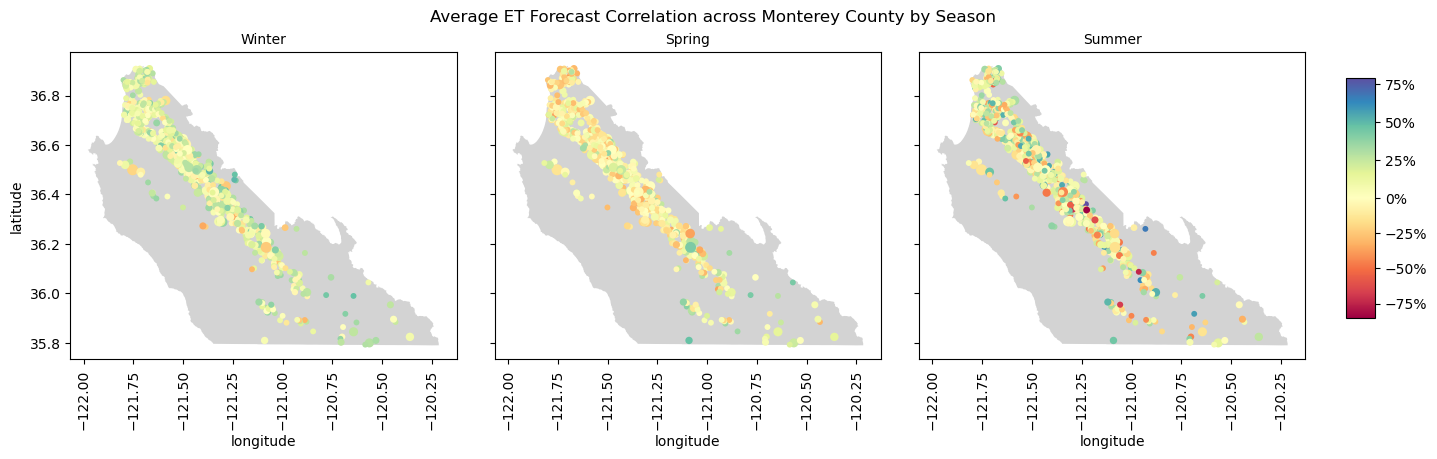

In [176]:
facet_geoscatter(et_seasonal, boundary_map=moco_geo, col='season', hue='corr', export_img="et_spatial_corr", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ET Forecast Correlation across Monterey County by Season", palette='Spectral');

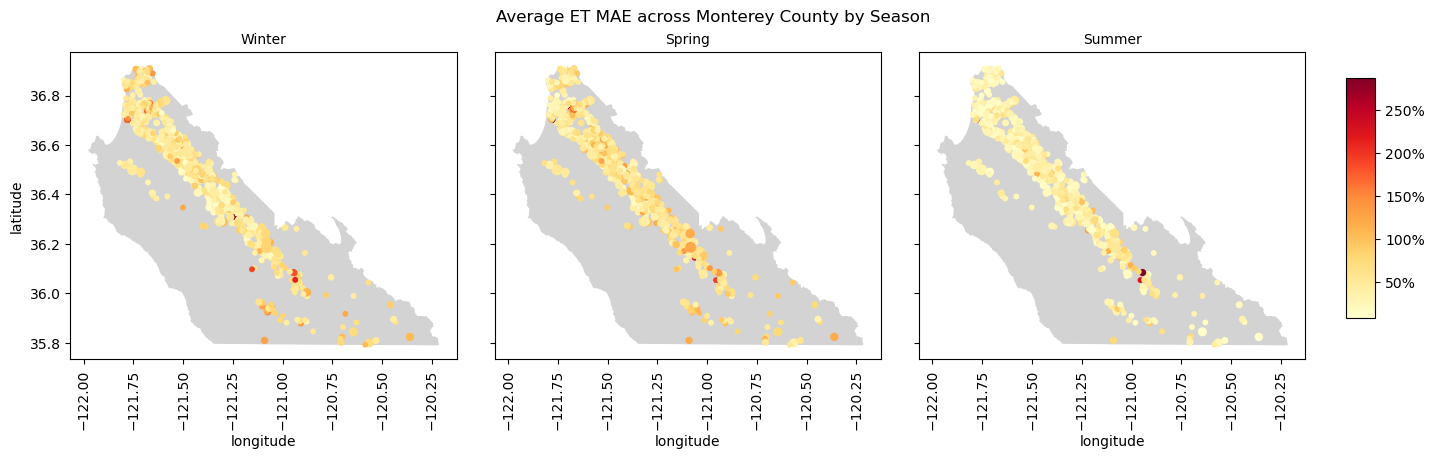

In [177]:
facet_geoscatter(et_seasonal, boundary_map=moco_geo, col='season', hue='mae',export_img="et_spatial_mae", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ET MAE across Monterey County by Season");

In [178]:
facet_geoscatter(et_seasonal, boundary_map=moco_geo, col='season', hue='rmse', export_img="et_spatial_rmse", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ET RMSE across Monterey County by Season");

In [179]:
facet_geoscatter(et_seasonal, boundary_map=moco_geo, col='season', hue='bias', palette='Spectral', export_img="et_spatial_bias", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ET Forecast Bias across Monterey County by Season");

##### ETo Visualization

In [180]:
eto_seasonal = seasonal_metrics[seasonal_metrics['variable'] == 'ETo']

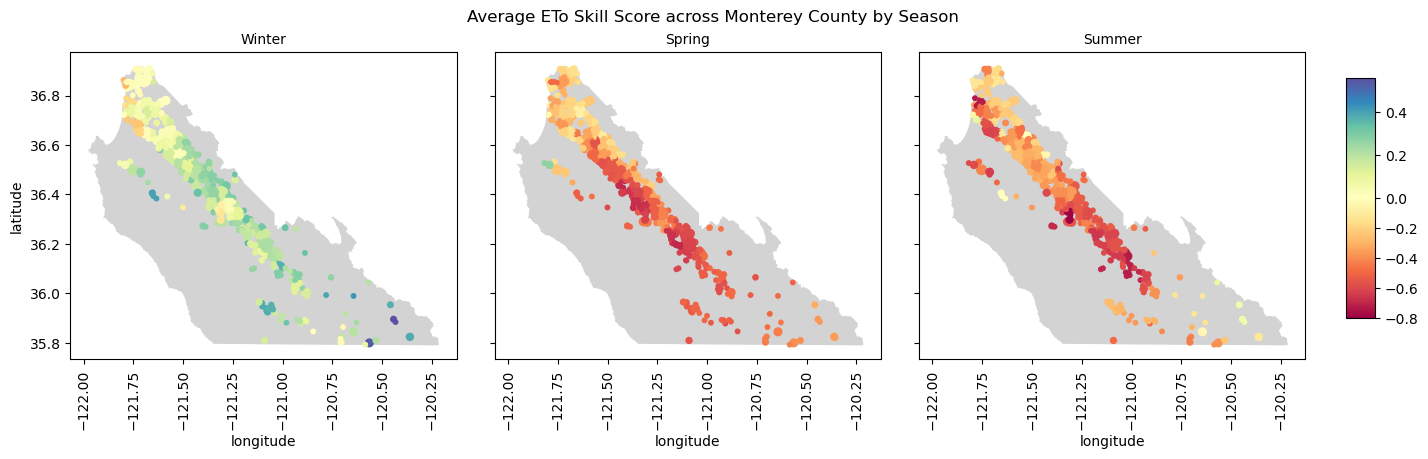

In [181]:
facet_geoscatter(eto_seasonal, boundary_map=moco_geo, col='season', hue='skill_score', export_img="eto_spatial_skill_score", as_percent=False, size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ETo Skill Score across Monterey County by Season", palette='Spectral');

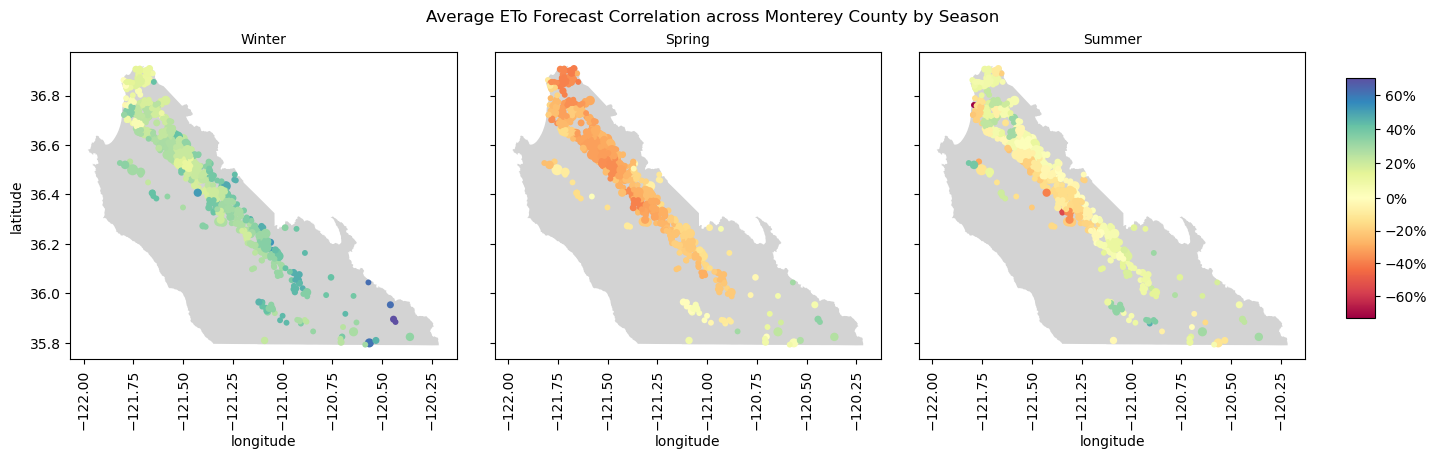

In [182]:
facet_geoscatter(eto_seasonal, boundary_map=moco_geo, col='season', hue='corr', export_img="eto_spatial_corr", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ETo Forecast Correlation across Monterey County by Season", palette='Spectral');

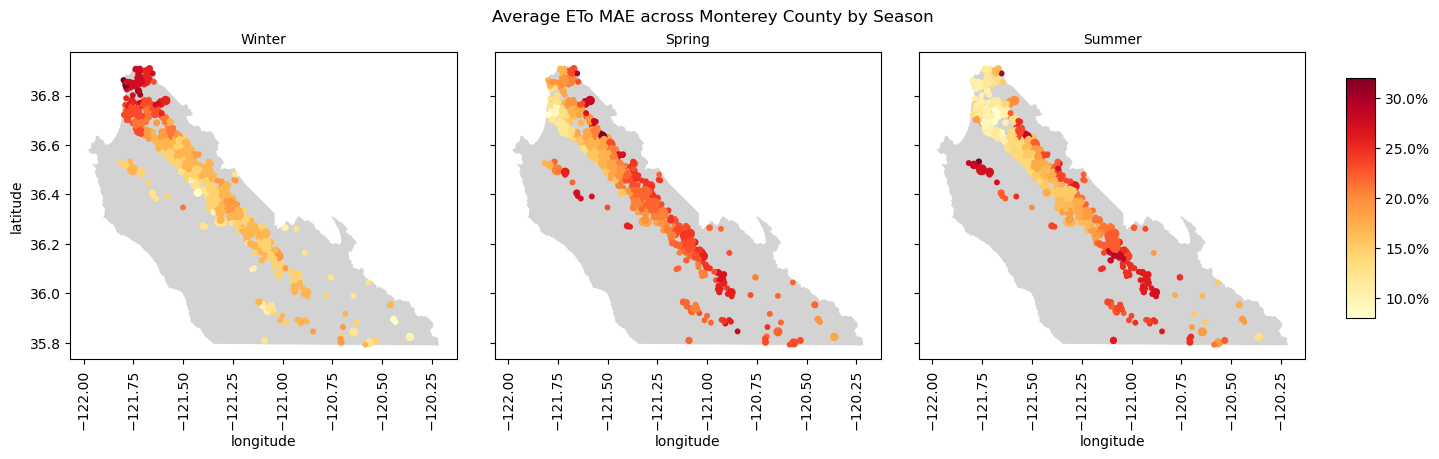

In [183]:
facet_geoscatter(eto_seasonal, boundary_map=moco_geo, col='season', hue='mae',export_img="eto_spatial_mae", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ETo MAE across Monterey County by Season");

In [184]:
facet_geoscatter(eto_seasonal, boundary_map=moco_geo, col='season', hue='rmse', export_img="eto_spatial_rmse", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ETo RMSE across Monterey County by Season");

In [185]:
facet_geoscatter(eto_seasonal, boundary_map=moco_geo, col='season', hue='bias', palette='Spectral', export_img="eto_spatial_bias", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ETo Forecast Bias across Monterey County by Season");

##### EToF Visualization

In [186]:
etof_seasonal = seasonal_metrics[seasonal_metrics['variable'] == 'ETof']

In [187]:
facet_geoscatter(etof_seasonal, boundary_map=moco_geo, col='season', hue='skill_score', size='markersize', export_img="etof_spatial_skill_score", as_percent=False,
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average EToF Skill Score across Monterey County by Season", palette='Spectral');

In [188]:
facet_geoscatter(etof_seasonal, boundary_map=moco_geo, col='season', hue='corr', size='markersize', export_img="etof_spatial_corr",
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average EToF Forecast Correlation across Monterey County by Season", palette='Spectral');

In [189]:
facet_geoscatter(etof_seasonal, boundary_map=moco_geo, col='season', hue='mae', size='markersize', export_img="etof_spatial_mae",
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average EToF MAE across Monterey County by Season");

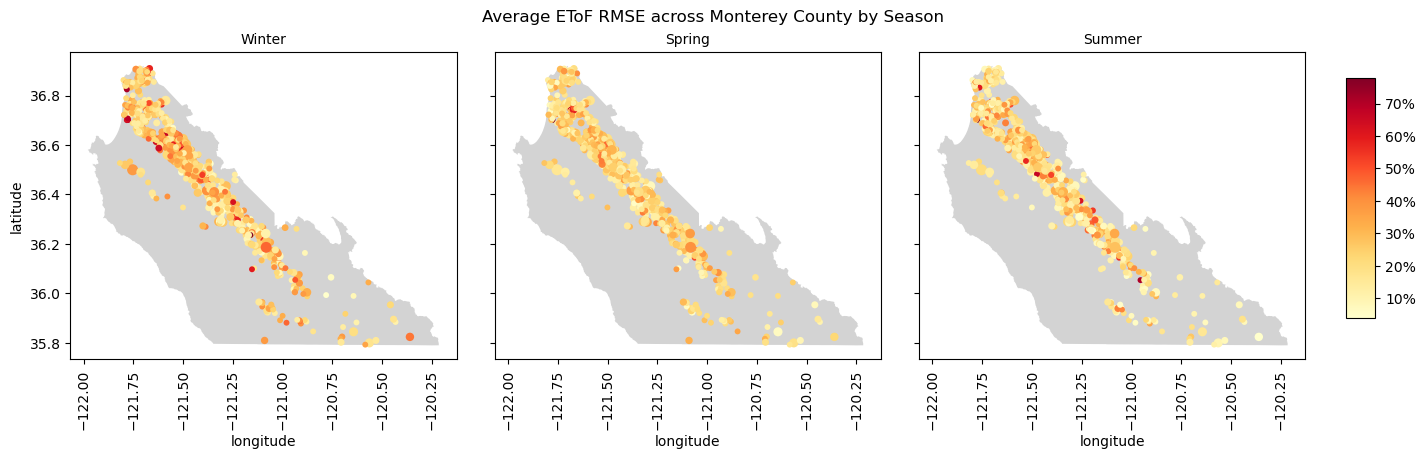

In [190]:
facet_geoscatter(etof_seasonal, boundary_map=moco_geo, col='season', hue='rmse', size='markersize', export_img="etof_spatial_rmse",
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average EToF RMSE across Monterey County by Season");

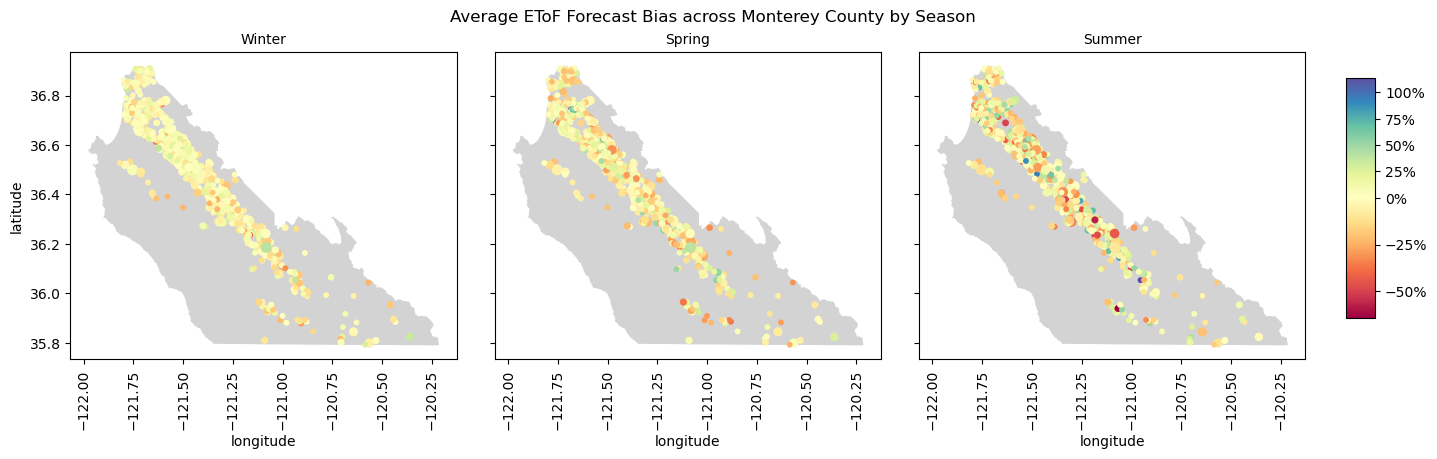

In [191]:
facet_geoscatter(etof_seasonal, boundary_map=moco_geo, col='season', hue='bias', size='markersize', palette='Spectral', export_img="etof_spatial_bias",
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average EToF Forecast Bias across Monterey County by Season");

#### Summer Overview

In [192]:
summer_metrics = seasonal_metrics[seasonal_metrics['season'] == 'Summer'][['field_id', 'variable', 'longitude', 'latitude', 'mae', 'bias', 'skill_score', 'markersize']]
summer_metrics = summer_metrics.melt(id_vars=['field_id', 'variable', 'longitude', 'latitude', 'markersize'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')
summer_metrics.head()

field_id variable   longitude   latitude  markersize stat  value
0  CA_244000       ET -121.540540  36.537255      6.3816  mae   0.64
1  CA_244000      ETo -121.540540  36.537255      6.3816  mae   0.15
2  CA_244000     ETof -121.540540  36.537255      6.3816  mae   0.41
3  CA_244018       ET -121.539709  36.547528      6.4326  mae   0.34
4  CA_244018      ETo -121.539709  36.547528      6.4326  mae   0.15

In [193]:
# Add subtitles into the data to insert into the plots
subtitle_dict = {
    'mae': 'Mean Absolute Error',
    'bias': 'Forecast Bias',
    'skill_score': 'Skill Score'
}
summer_metrics['name'] = summer_metrics['stat'].map(subtitle_dict)

In [194]:
# Keyword for double-sided legend
sm_skill_score = summer_metrics[summer_metrics['stat'] == 'skill_score']

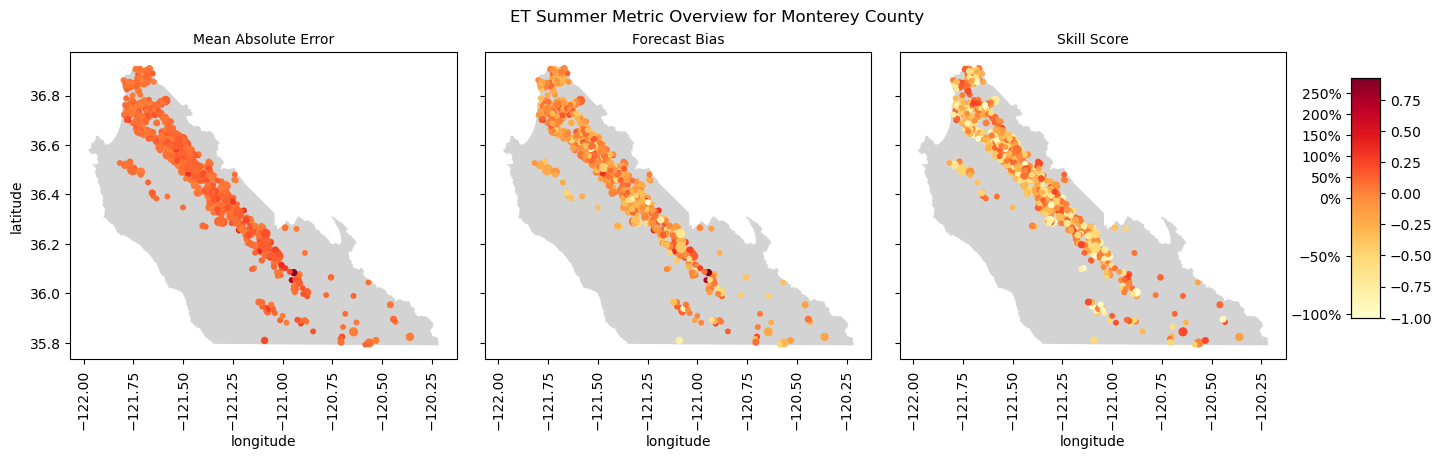

In [195]:
# Create subplot grid for each metric
g = facet_geoscatter(summer_metrics[summer_metrics['variable'] == 'ET'], boundary_map=moco_geo, col='name', hue='value', size='markersize', normalize_cmap=True,
                     title='ET Summer Metric Overview for Monterey County', title_template={"template": "{col_name}"}, export_img="et_summer_spatial",
                     double_legend=sm_skill_score[sm_skill_score['variable'] == 'ET']);

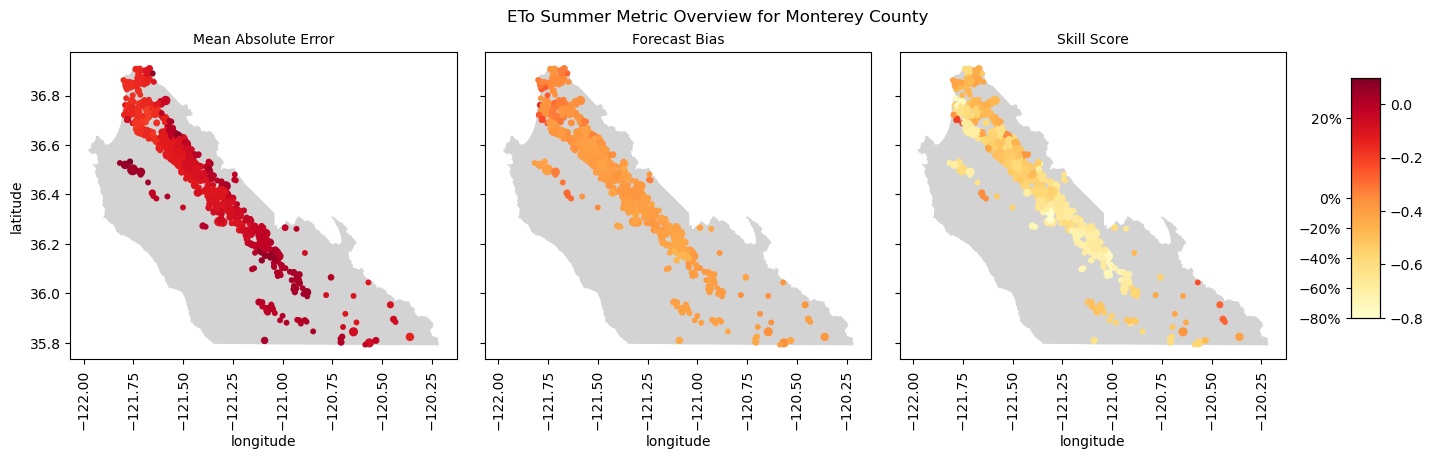

In [196]:
# Create subplot grid for each metric
g = facet_geoscatter(summer_metrics[summer_metrics['variable'] == 'ETo'], boundary_map=moco_geo, col='name', hue='value', size='markersize', normalize_cmap=True,
                     title='ETo Summer Metric Overview for Monterey County', title_template={"template": "{col_name}"}, export_img="eto_summer_spatial",
                     double_legend=sm_skill_score[sm_skill_score['variable'] == 'ETo']);

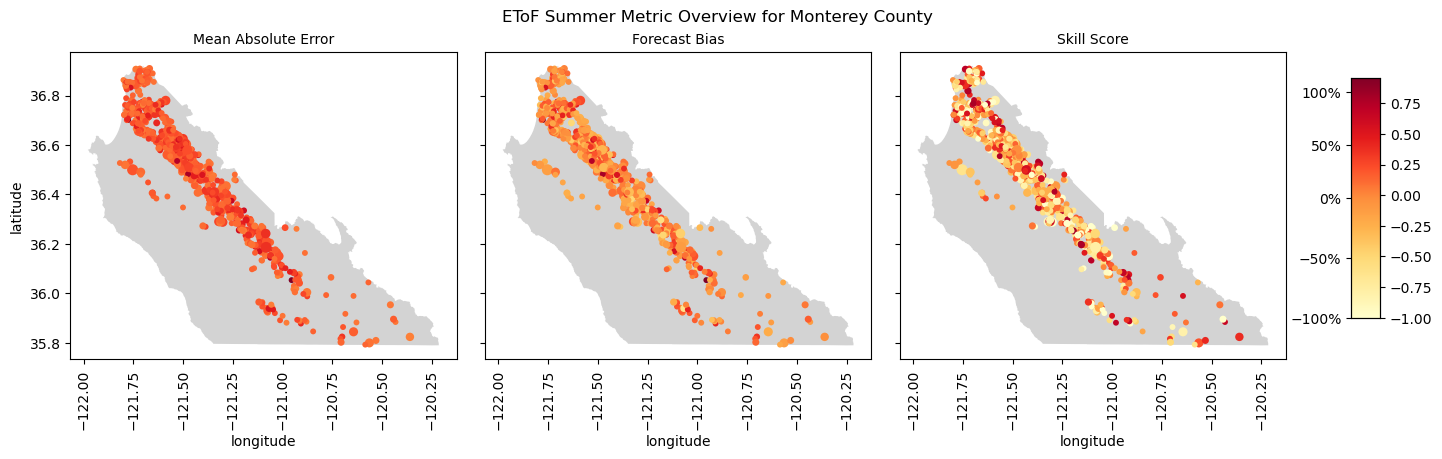

In [197]:
# Create subplot grid for each metric
g = facet_geoscatter(summer_metrics[summer_metrics['variable'] == 'ETof'], boundary_map=moco_geo, col='name', hue='value', size='markersize', normalize_cmap=True,
                     title='EToF Summer Metric Overview for Monterey County', title_template={"template": "{col_name}"}, export_img="etof_summer_spatial",
                     double_legend=sm_skill_score[sm_skill_score['variable'] == 'ETof']);

## Polygon Analysis

Polygon analysis is conducted on a set of worst performing fields based on Mean Absolute Error. This analysis is conducted to see if polygon forecasting is more accurate than point forecasting.

In [198]:
# Styling Cell
sns.set_theme(context="notebook", style="whitegrid")

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Historical Import

In [199]:
poly_historical = pd.read_csv('./data/monterey_polygon_large_historical.csv', low_memory=False)
poly_historical['time'] = pd.to_datetime(poly_historical['time'])
poly_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156850 entries, 0 to 156849
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   field_id     156850 non-null  object        
 1   crop         156850 non-null  int64         
 2   time         156850 non-null  datetime64[ns]
 3   actual_et    156850 non-null  float64       
 4   actual_eto   156850 non-null  float64       
 5   actual_etof  156850 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 7.2+ MB


In [200]:
poly_fields = poly_historical['field_id'].unique()

### Forecast Table

In [201]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"data/forecasts/0.0.1/polygon/monterey/sampled").glob("*.csv")

for file in files:
    # splits into [$date, 'forecast.csv']
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567300 entries, 0 to 567299
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   field_id          567300 non-null  object        
 1   crop              567300 non-null  int64         
 2   time              567300 non-null  datetime64[ns]
 3   expected_et       567300 non-null  float64       
 4   expected_eto      567300 non-null  float64       
 5   expected_etof     567300 non-null  float64       
 6   forecasting_date  567300 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 30.3+ MB


### Main Table Compilation

In [202]:
poly_dt = poly_historical.loc[(poly_historical['time'].dt.year == 2024), :]
poly_dt = poly_dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
poly_dt

forecasting_date   field_id  crop       time  actual_et  actual_eto  \
0            2024-07-15  CA_244113    47 2024-01-01      0.383       0.927   
1            2024-07-15  CA_244113    47 2024-01-02      0.315       0.721   
2            2024-07-15  CA_244113    47 2024-01-03      0.664       1.442   
3            2024-07-15  CA_244113    47 2024-01-04      0.838       1.853   
4            2024-07-15  CA_244113    47 2024-01-05      0.502       1.133   
...                 ...        ...   ...        ...        ...         ...   
567295       2024-01-29  CA_257924    47 2024-12-27        NaN         NaN   
567296       2024-01-29  CA_257924    47 2024-12-28        NaN         NaN   
567297       2024-01-29  CA_257924    47 2024-12-29        NaN         NaN   
567298       2024-01-29  CA_257924    47 2024-12-30        NaN         NaN   
567299       2024-01-29  CA_257924    47 2024-12-31        NaN         NaN   

        actual_etof  expected_et  expected_eto  expected_etof  
0             0.413        0.383         0.927          0.413  
1             0.437        0.315         0.721          0.437  
2             0.461        0.664         1.442          0.461  
3             0.452        0.838         1.853          0.452  
4             0.443        0.502         1.133          0.443  
...             ...          ...           ...            ...  
567295          NaN        0.523         1.531          0.822  
567296          NaN        0.520         1.420          0.819  
567297          NaN        0.540         1.293          0.818  
567298          NaN        0.566         1.228          0.809  
567299          NaN        0.552         1.030          0.800  

[567300 rows x 10 columns]

### Reference Tables

#### Average ET/ETo/ETof for 2024

In [203]:
poly_avgs = poly_dt.groupby(['field_id', 'crop'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
poly_avgs.head()

actual_et  actual_eto  actual_etof
field_id  crop                                    
CA_244113 47     1.401321    4.967302     0.410698
CA_244387 61     2.214777    3.457363     0.752247
CA_244479 47     3.370209    3.194358     1.048688
CA_245292 47     2.773167    4.085907     0.728819
CA_246341 47     1.316763    4.713772     0.413447

#### Climatology Reference

In [204]:
# Create a column for day of year
poly_historical['doy'] = poly_historical['time'].dt.dayofyear
# Group by field, crop, and doy then calculate the average conditions
poly_climatology = poly_historical.groupby(['field_id', 'crop', 'doy'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
poly_climatology

actual_et  actual_eto  actual_etof
field_id  crop doy                                    
CA_244113 47   1     0.459333    0.915556     0.532778
               2     0.572778    1.075778     0.536667
               3     0.713889    1.293000     0.540556
               4     0.717556    1.384333     0.540889
               5     0.619333    1.247222     0.546556
...                       ...         ...          ...
CA_257924 47   362   0.898500    1.020875     0.863000
               363   0.921375    1.109500     0.826000
               364   0.800125    0.965375     0.836625
               365   0.684875    0.798750     0.847250
               366   0.660000    0.532500     1.087500

[18300 rows x 3 columns]

### Accuracy Metric Calculation

In [205]:
# poly_metrics = (poly_dt[(poly_dt['time'] > poly_dt['forecasting_date']) & (poly_dt['time'] < (poly_dt['forecasting_date']) + timedelta(days=7)) & (poly_dt['time'] < analysis_end_date)]
#                 .groupby(['forecasting_date'])[list(poly_dt.columns)]
#                 .apply(eval_metrics, normalize=True, climatology_ref=poly_climatology, avgs_ref=poly_avgs))
# poly_metrics.reset_index().to_csv('data/metrics/monterey_poly_metrics.csv', index=False)

In [206]:
poly_metrics = pd.read_csv('data/metrics/monterey_poly_metrics.csv').drop(['level_1'], axis=1)
poly_metrics['forecasting_date'] = pd.to_datetime(poly_metrics['forecasting_date'])

### Visualization

In [207]:
# First reshape data from wide-form to long-form
poly_metrics_long = poly_metrics.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')
poly_metrics_long['name'] = poly_metrics_long['stat'].map(stat_propers)

#### Interquartile Metrics

In [208]:
rel = timeseries_rel(poly_metrics_long, row='variable', col='name', y='value',
                     errorbar='sd', estimator=np.median, as_percent=True,
                     refline={'y': 0},
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True}, aspect=1.5,
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Poly Accuracy Interquartile Metrics (n=50)");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('images/monterey/poly_field_metric_range_sd.png')

#### Point vs Polygon Comparison

A comparison is made against the same fields specified by the Polygon table.

In [209]:
point_cmp_metrics = metrics_long[metrics_long['field_id'].isin(poly_fields)]

In [210]:
point_cmp_metrics.loc[:, 'shape'] = 'point'
poly_metrics_long['shape'] = 'polygon'
poly_metrics_long = poly_metrics_long.join(cdl_codes, how="left", on="crop", validate="many_to_many")

shape_metrics_long = pd.concat([point_cmp_metrics, poly_metrics_long])
shape_metrics_long

/tmp/ipykernel_136676/1698300882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_cmp_metrics.loc[:, 'shape'] = 'point'


forecasting_date   field_id  crop variable         stat  value  \
10          2024-01-01  CA_244113    47       ET          mae   0.09   
24          2024-01-01  CA_244387    61       ET          mae   0.25   
32          2024-01-01  CA_244479    47       ET          mae   0.13   
63          2024-01-01  CA_245292    47       ET          mae   0.17   
108         2024-01-01  CA_246341    47       ET          mae   0.24   
...                ...        ...   ...      ...          ...    ...   
13945       2024-07-29  CA_257473    47       ET  skill_score   0.83   
13946       2024-07-29  CA_257648    47       ET  skill_score  -1.00   
13947       2024-07-29  CA_257744    47       ET  skill_score  -1.00   
13948       2024-07-29  CA_257756    47       ET  skill_score  -1.00   
13949       2024-07-29  CA_257924    47       ET  skill_score  -1.00   

                      name           Class_Names  ESRI_Red  ESRI_Green  \
10     Mean Absolute Error    Misc Vegs & Fruits       255         102   
24     Mean Absolute Error  Fallow/Idle Cropland       191         191   
32     Mean Absolute Error    Misc Vegs & Fruits       255         102   
63     Mean Absolute Error    Misc Vegs & Fruits       255         102   
108    Mean Absolute Error    Misc Vegs & Fruits       255         102   
...                    ...                   ...       ...         ...   
13945          Skill Score    Misc Vegs & Fruits       255         102   
13946          Skill Score    Misc Vegs & Fruits       255         102   
13947          Skill Score    Misc Vegs & Fruits       255         102   
13948          Skill Score    Misc Vegs & Fruits       255         102   
13949          Skill Score    Misc Vegs & Fruits       255         102   

       ESRI_Blue  Erdas_Red  Erdas_Green  Erdas_Blue aligned    shape  
10           102      1.000        0.400      0.4000   False    point  
24           122      0.749        0.749      0.4667   False    point  
32           102      1.000        0.400      0.4000   False    point  
63           102      1.000        0.400      0.4000   False    point  
108          102      1.000        0.400      0.4000   False    point  
...          ...        ...          ...         ...     ...      ...  
13945        102      1.000        0.400      0.4000     NaN  polygon  
13946        102      1.000        0.400      0.4000     NaN  polygon  
13947        102      1.000        0.400      0.4000     NaN  polygon  
13948        102      1.000        0.400      0.4000     NaN  polygon  
13949        102      1.000        0.400      0.4000     NaN  polygon  

[26835 rows x 16 columns]

##### Interquartile Comparison

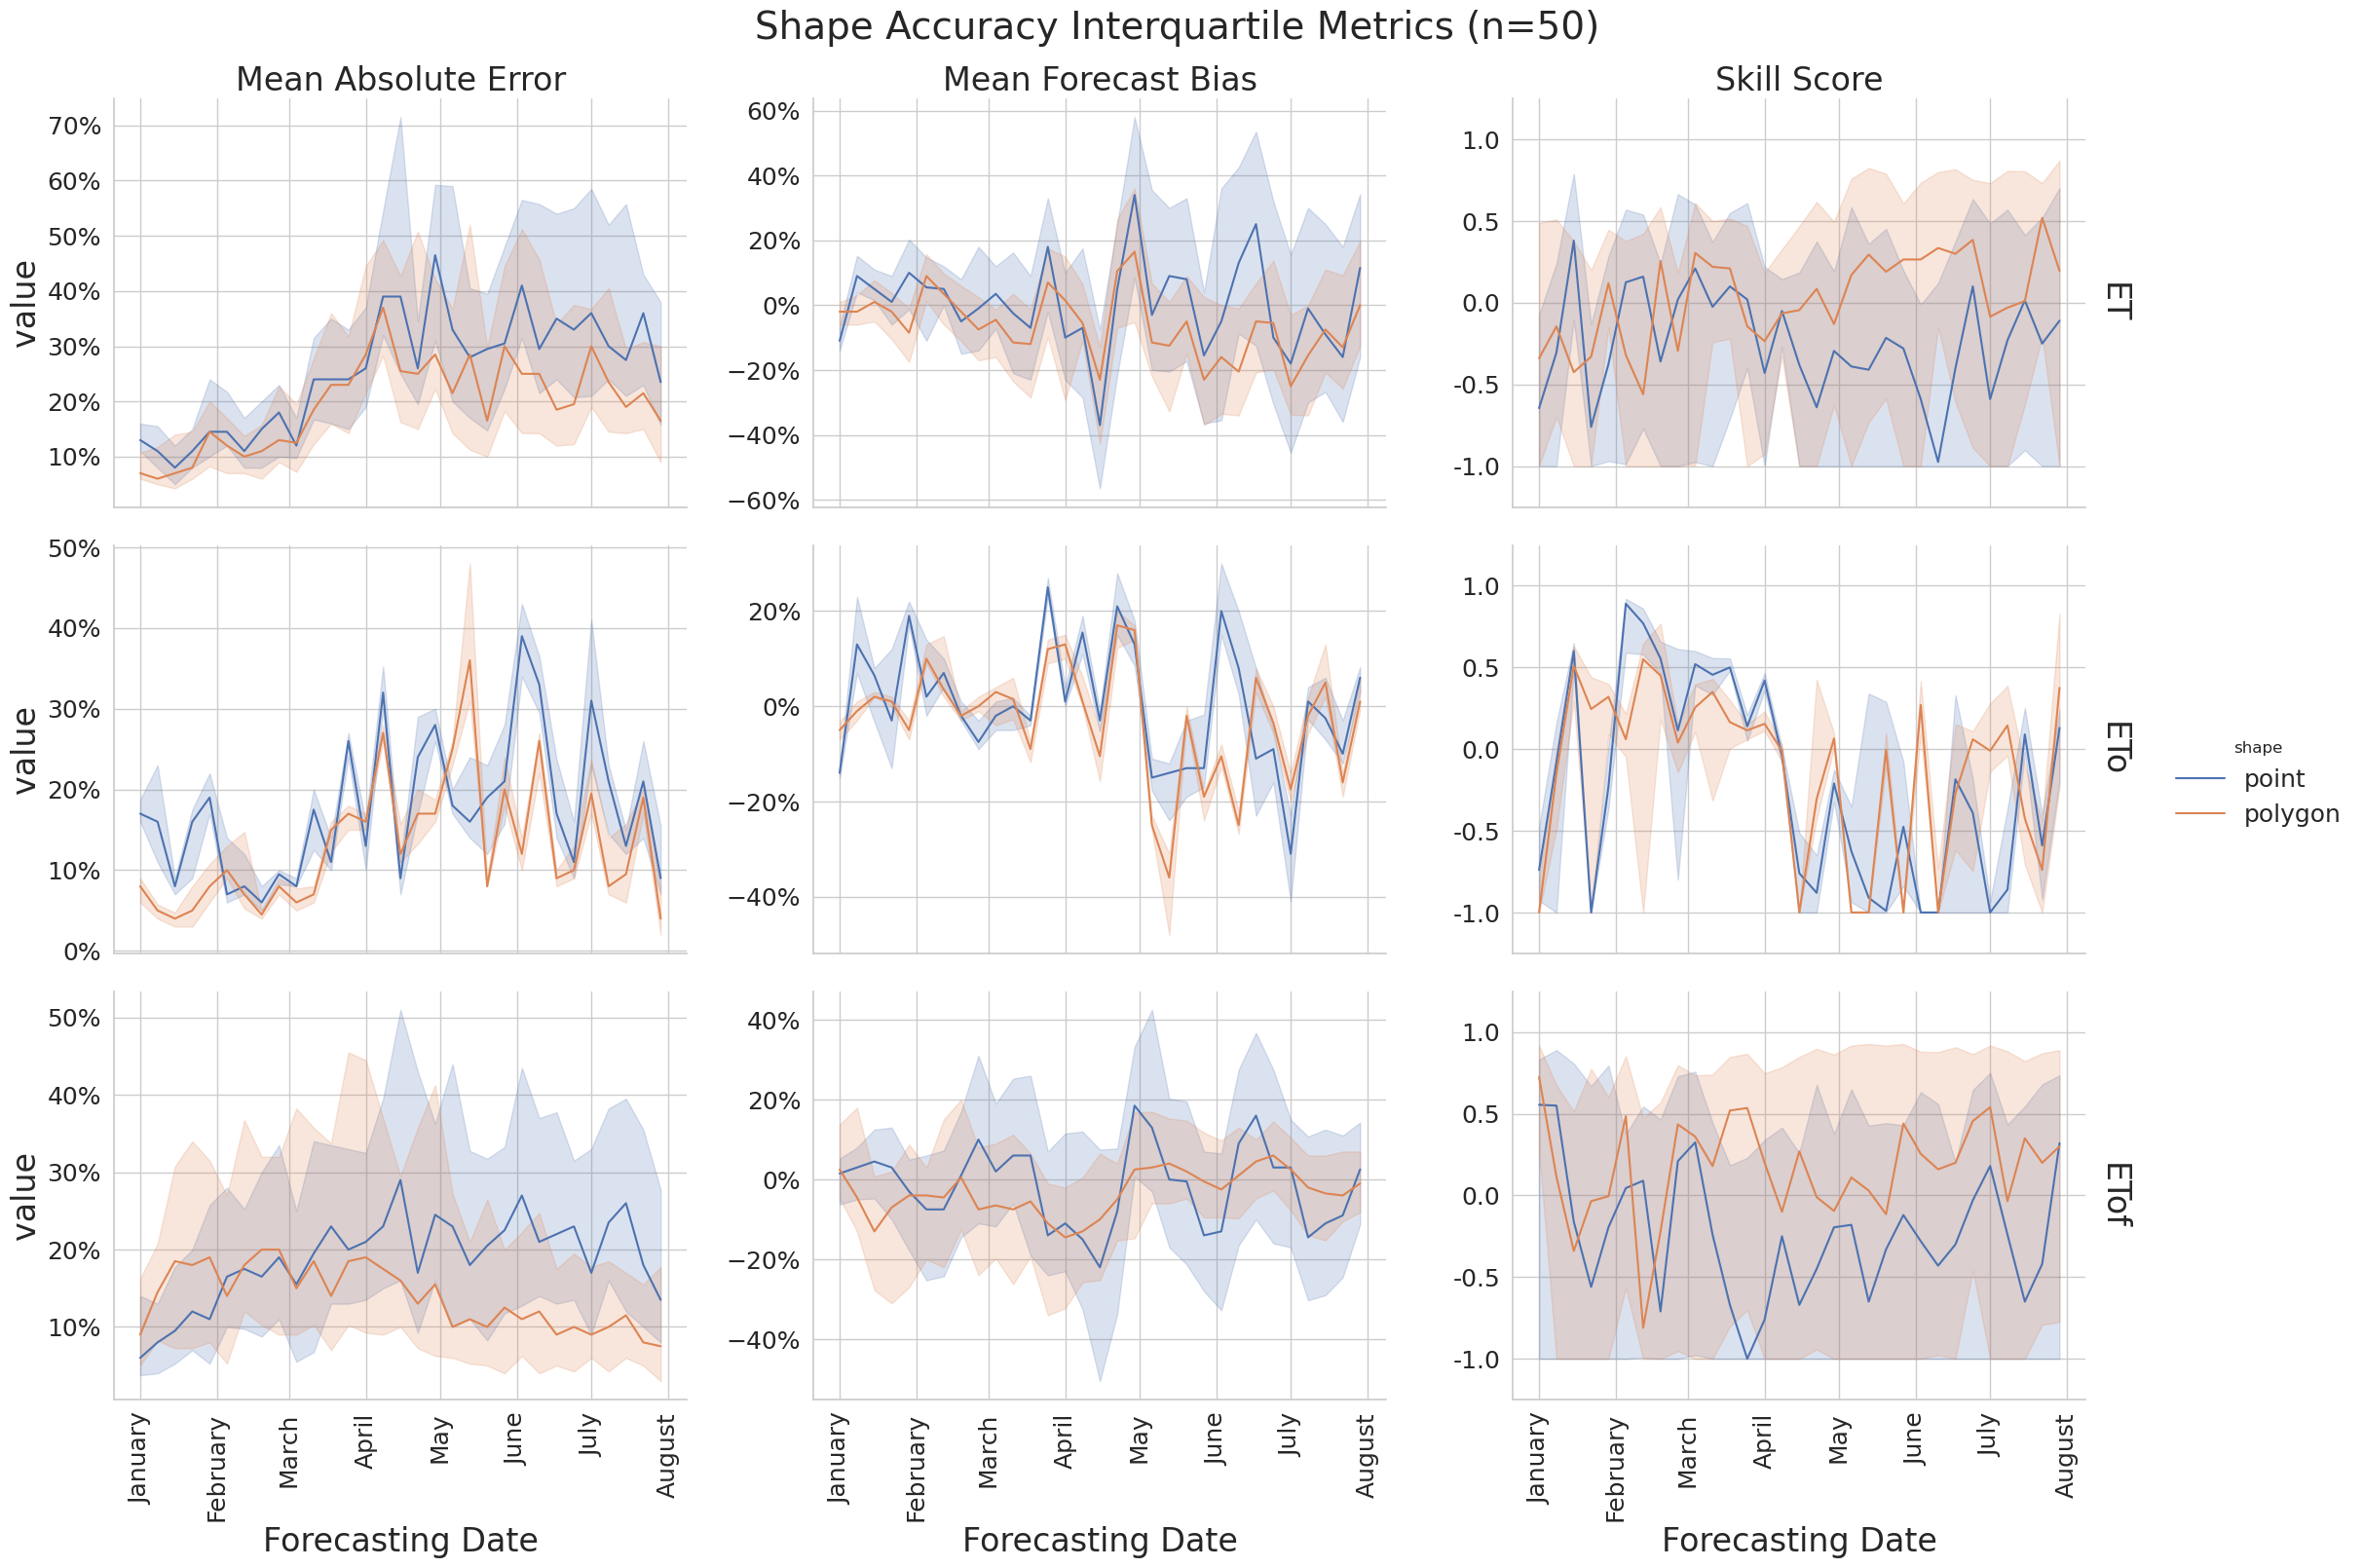

In [211]:
rel = timeseries_rel(shape_metrics_long, row='variable', col='name', y='value', hue='shape',
                     errorbar=("pi", 50), estimator=np.median, as_percent=True,
                     # refline={'y': 0},
                     facet_kws={'sharey': False, 'sharex': True, 'margin_titles': True}, aspect=1.5,
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Shape Accuracy Interquartile Metrics (n=50)");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[5].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[5].set(ylim=(-1.25, 1.25));
rel.axes.flat[5].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[8].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[8].set(ylim=(-1.25, 1.25));
rel.axes.flat[8].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('images/monterey/shape_comparison.png')

# Crop Comparison

In [212]:
shape_crop_plotter = shape_metrics_long[shape_metrics_long['crop'].isin(crop_selector)]
shape_crop_plotter.head()

forecasting_date   field_id  crop variable stat  value  \
10        2024-01-01  CA_244113    47       ET  mae   0.09   
32        2024-01-01  CA_244479    47       ET  mae   0.13   
63        2024-01-01  CA_245292    47       ET  mae   0.17   
108       2024-01-01  CA_246341    47       ET  mae   0.24   
118       2024-01-01  CA_246587    47       ET  mae   0.16   

                    name         Class_Names  ESRI_Red  ESRI_Green  ESRI_Blue  \
10   Mean Absolute Error  Misc Vegs & Fruits       255         102        102   
32   Mean Absolute Error  Misc Vegs & Fruits       255         102        102   
63   Mean Absolute Error  Misc Vegs & Fruits       255         102        102   
108  Mean Absolute Error  Misc Vegs & Fruits       255         102        102   
118  Mean Absolute Error  Misc Vegs & Fruits       255         102        102   

     Erdas_Red  Erdas_Green  Erdas_Blue aligned  shape  
10         1.0          0.4         0.4   False  point  
32         1.0          0.4         0.4   False  point  
63         1.0          0.4         0.4   False  point  
108        1.0          0.4         0.4   False  point  
118        1.0          0.4         0.4   False  point

In [ ]:
shape_crop_plotter['Class_Names'] = shape_crop_plotter['Class_Names'].apply(lambda x: f'{x} ({shape_crop_plotter['field_id'][shape_crop_plotter['Class_Names'] == x].nunique()})')

In [ ]:
rel = timeseries_rel(shape_crop_plotter[shape_crop_plotter['variable'] == 'ET'], y='value', plot='rel', kind='line',
                        col='Class_Names', row='name', hue='shape',
                        # refline={'y': 0},
                        facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.1, 'hspace': 0.1}}, 
                        estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                        title='Interquartile ET Crop Shape Accuracy Comparison', as_percent=True);
rel.axes.flat[4].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[4].set(ylim=(-1.25, 1.25));
rel.axes.flat[4].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("images/monterey/et_crop_shape_compare.png");

In [ ]:
rel = timeseries_rel(shape_crop_plotter[shape_crop_plotter['variable'] == 'ETo'], y='value', plot='rel', kind='line',
                        col='Class_Names', row='name', hue='shape',
                        # refline={'y': 0},
                        facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.1, 'hspace': 0.1}}, 
                        estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                        title='Interquartile ETo Crop Shape Accuracy Comparison', as_percent=True);
rel.axes.flat[4].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[4].set(ylim=(-1.25, 1.25));
rel.axes.flat[4].set_yticks((1, 0.5, 0, -0.5, -1));
# rel.savefig("images/monterey/eto_crop_shape_compare.png")

In [ ]:
rel = timeseries_rel(shape_crop_plotter[shape_crop_plotter['variable'] == 'ETof'], y='value', plot='rel', kind='line',
                        col='Class_Names', row='name', hue='shape',
                        # refline={'y': 0},
                        facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.1, 'hspace': 0.1}}, 
                        estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                        title='Interquartile ETof Crop Shape Accuracy Comparison', as_percent=True);
rel.axes.flat[4].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[4].set(ylim=(-1.25, 1.25));
rel.axes.flat[4].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("images/monterey/etof_crop_shape_compare.png")